The research conducted in this notebook addresses the task of predicting the remaining useful life (RUL) of turbofan engines, which was first introduced by NASA in 2008 for a challenge competition at a conference on Prognostics and Health Management. To achieve this goal, two approaches involving neural networks were developed to work with multivariate time series data. The dataset, also known as PHM08, comprises 218 engines, each identified by a unique ID. Information about the engine settings (features setting1, setting2, and setting3) and data from 21 sensors (features s1 to s21) are recorded at each cycle of engine operation. Initially, each engine operates normally, but deviations from the norm in sensor readings occur after a certain number of cycles, eventually leading to failure.

For the purpose of training and validation, 60 engines were reserved for the training set, and 30 engines were used for the validation set. An additional 30 engines were randomly selected for the test set. The objective is to train a model to identify the state of engines in the training set and then predict the state (number of cycles until failure) of each engine in the test set based on sensor data and settings.

The target variable is binarized to classify engine states into two discrete categories: normal operation and impending failure, where the last 30 cycles of engine operation are designated as the "failure state" or "impending failure state." This approach enables the model to learn to discriminate between periods of stable operation and instances where the engine exhibits characteristics indicative of imminent malfunction or degradation.

The first approach proposed involves treating the multivariate times series as images of size 50x50 with the number of channels equal to the number of features and fine-tuning a popular pre-trained architecture like Xception to classify the images into one of the two categories explained above. Another apporach is used for comparison. It utilizes an implementation of the new KAN (Kolmogorov-Arnold Networks) architecture and explores its potential in the field of predictive maintenance and reliability engineering.

In [1]:
pip install dcor pretrainedmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached n

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

import copy
import random
import time
from tqdm.notebook import tqdm, trange
from collections import Counter
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch import sigmoid, round as t_round
from torch.optim.lr_scheduler import _LRScheduler
import torchvision.transforms as transforms

from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, classification_report, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.spatial.distance import pdist, squareform

from dcor import distance_correlation

import pretrainedmodels

import warnings

In [5]:
warnings.filterwarnings("ignore", category = FutureWarning)

In [6]:
warnings.filterwarnings("ignore", message = ".*DataFrame is highly fragmented.*")

In [7]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.min_rows', 100)

In [8]:
df = pd.read_csv('gdrive/MyDrive/ML/projects/predictive-maintenance/dataset.txt', sep = " ", header = None)

In [9]:
df.drop(labels = [26, 27], axis = 1, inplace = True)

df.columns = ['unit', 'work_cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
              's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
              's15', 's16', 's17', 's18', 's19', 's20', 's21']

df = df.sort_values(['unit','work_cycle'])

In [10]:
df.head()

unit  work_cycle  setting1  setting2  setting3      s1      s2       s3  \
0     1           1   10.0047    0.2501      20.0  489.05  604.13  1499.45   
1     1           2    0.0015    0.0003     100.0  518.67  642.13  1584.55   
2     1           3   34.9986    0.8401      60.0  449.44  555.42  1368.17   
3     1           4   20.0031    0.7005       0.0  491.19  607.03  1488.44   
4     1           5   42.0041    0.8405      40.0  445.00  549.52  1354.48   

        s4     s5     s6      s7       s8       s9   s10    s11     s12  \
0  1309.95  10.52  15.49  394.88  2318.87  8770.20  1.26  45.40  372.15   
1  1403.96  14.62  21.61  553.67  2388.01  9045.76  1.30  47.29  521.81   
2  1122.49   5.48   8.00  194.93  2222.86  8343.91  1.02  41.92  183.26   
3  1249.18   9.35  13.65  334.82  2323.85  8721.53  1.08  44.26  314.84   
4  1124.32   3.91   5.71  138.24  2211.80  8314.56  1.02  41.79  130.44   

       s13      s14     s15   s16  s17   s18    s19    s20      s21  
0  2388.13  8120.83  8.6216  0.03  368  2319  100.0  28.58  17.1735  
1  2388.15  8132.87  8.3907  0.03  391  2388  100.0  38.99  23.3619  
2  2387.95  8063.84  9.3557  0.02  334  2223  100.0  14.83   8.8555  
3  2388.07  8052.30  9.2231  0.02  364  2324  100.0  24.42  14.7832  
4  2387.89  8083.67  9.2986  0.02  330  2212  100.0  10.99   6.4025

This code generates a set of new columns containing rolling window statistics, providing additional features that capture temporal patterns and trends in the data.

In [11]:
basic_features = ['setting1', 'setting2', 'setting3',
                  's1', 's2', 's3', 's4', 's5', 's6',
                  's7', 's8', 's9', 's10', 's11', 's12',
                  's13', 's14', 's15', 's16', 's17', 's18',
                  's19', 's20', 's21']

new_columns = []

windows = [5, 10, 15, 30]

for feature in basic_features:
  for window in windows:
    new_columns.append(df.groupby('unit')[feature].transform(lambda x: x.rolling(window).mean()).rename(f'rolling_{window}_mean_{feature}'))
    new_columns.append(df.groupby('unit')[feature].transform(lambda x: x.rolling(window).std()).rename(f'rolling_{window}_std_{feature}'))
    new_columns.append(df.groupby('unit')[feature].transform(lambda x: x.rolling(window).max()).rename(f'rolling_{window}_max_{feature}'))
    new_columns.append(df.groupby('unit')[feature].transform(lambda x: x.rolling(window).min()).rename(f'rolling_{window}_min_{feature}'))
    new_columns.append(df.groupby('unit')[feature].transform(lambda x: x.rolling(window).skew()).rename(f'rolling_{window}_skew_{feature}'))
    new_columns.append(df.groupby('unit')[feature].transform(lambda x: x.rolling(window).kurt()).rename(f'rolling_{window}_kurt_{feature}'))

In [12]:
df = pd.concat([df] + new_columns, axis = 1)

In [13]:
df.shape

(45918, 602)

The code sets up the indices for splitting the dataset into training, validation, and test sets. It does so by first fixing a random seed for reproducibility, then randomly selecting units that will not be included in the training set, and finally splitting these non-training units into validation and test sets.

In [14]:
np.random.seed(888)

not_train = np.random.choice(range(1, 219), 60, replace = False)
val_index = not_train[:30]
test_index = not_train[30:]

The code calculates the Remaining Useful Life (RUL) for each unit in the dataset and creates a binary label indicating whether a unit is close to failure. Units with an RUL less than 30 cycles are labeled as 1 (near failure), while those with an RUL of 30 cycles or more are labeled as 0 (not near failure).

In [15]:
df['RUL'] = df.groupby(['unit'])['work_cycle'].transform(max) - df['work_cycle']

In [16]:
w1 = 30
df['label'] = np.where(df['RUL'] < w1, 1, 0)

The code prepares the data for feature selection by excluding non-training units, handling missing values, and shuffling the data. It then standardizes the features and performs Recursive Feature Elimination (RFE) using a Support Vector Classifier (SVC) to select the most relevant features. We specify that we want to select 20% of the features (n_features_to_select = 0.2) and to eliminate 10 features in each step (step = 10). Finally, it extracts the selected features into a new dataframe. This process helps in identifying the most informative features for building a robust machine learning model.

In [17]:
df_feature_selection = df[~df['unit'].isin(not_train)]
df_feature_selection = df_feature_selection.dropna(axis = 0).reset_index(drop = True)
df_feature_selection.drop(['unit', 'RUL'], axis = 1, inplace = True)
df_feature_selection = df_feature_selection.sample(frac = 1).reset_index(drop = True)

In [18]:
scaler = StandardScaler()

X_feature_selection = scaler.fit_transform(df_feature_selection.drop(['label'], axis = 1))
y_feature_selection = df_feature_selection['label'].values

In [19]:
svc_model = SVC(kernel = 'linear', C = 0.1)
feature_selector = RFE(svc_model, n_features_to_select = 0.2, step = 10)

In [20]:
#selector = feature_selector.fit(X_feature_selection, y_feature_selection)

In [21]:
#rfe_selected_features = df_feature_selection.columns[:-1][selector.support_]
rfe_selected_features = ['work_cycle',
 's1',
 's4',
 's11',
 's14',
 's15',
 'rolling_5_max_setting1',
 'rolling_5_min_setting1',
 'rolling_10_min_setting1',
 'rolling_30_min_setting1',
 'rolling_5_min_setting2',
 'rolling_10_min_setting2',
 'rolling_15_mean_setting2',
 'rolling_15_skew_setting2',
 'rolling_30_min_setting2',
 'rolling_30_skew_setting2',
 'rolling_15_mean_setting3',
 'rolling_15_max_setting3',
 'rolling_5_mean_s1',
 'rolling_5_max_s1',
 'rolling_5_min_s1',
 'rolling_10_mean_s1',
 'rolling_15_mean_s1',
 'rolling_15_skew_s1',
 'rolling_5_min_s2',
 'rolling_15_skew_s2',
 'rolling_30_max_s2',
 'rolling_10_mean_s3',
 'rolling_15_mean_s3',
 'rolling_15_max_s3',
 'rolling_15_min_s3',
 'rolling_15_skew_s3',
 'rolling_5_mean_s4',
 'rolling_5_max_s4',
 'rolling_5_min_s4',
 'rolling_10_mean_s4',
 'rolling_10_max_s4',
 'rolling_10_min_s4',
 'rolling_15_mean_s4',
 'rolling_15_max_s4',
 'rolling_30_mean_s4',
 'rolling_30_kurt_s4',
 'rolling_10_min_s6',
 'rolling_30_std_s7',
 'rolling_30_max_s7',
 'rolling_10_max_s8',
 'rolling_30_std_s8',
 'rolling_30_min_s8',
 'rolling_30_kurt_s8',
 'rolling_5_mean_s9',
 'rolling_5_max_s9',
 'rolling_10_mean_s9',
 'rolling_10_max_s9',
 'rolling_10_skew_s9',
 'rolling_30_mean_s9',
 'rolling_30_max_s9',
 'rolling_30_skew_s9',
 'rolling_5_min_s10',
 'rolling_15_skew_s10',
 'rolling_30_std_s10',
 'rolling_5_mean_s11',
 'rolling_5_max_s11',
 'rolling_5_min_s11',
 'rolling_10_mean_s11',
 'rolling_10_max_s11',
 'rolling_10_skew_s11',
 'rolling_15_mean_s11',
 'rolling_15_max_s11',
 'rolling_15_kurt_s11',
 'rolling_30_mean_s11',
 'rolling_30_std_s11',
 'rolling_30_min_s11',
 'rolling_30_skew_s11',
 'rolling_10_max_s13',
 'rolling_30_max_s13',
 'rolling_5_mean_s14',
 'rolling_5_min_s14',
 'rolling_10_mean_s14',
 'rolling_10_max_s14',
 'rolling_15_mean_s14',
 'rolling_15_min_s14',
 'rolling_15_kurt_s14',
 'rolling_30_mean_s14',
 'rolling_30_max_s14',
 'rolling_30_min_s14',
 'rolling_5_mean_s15',
 'rolling_5_max_s15',
 'rolling_5_min_s15',
 'rolling_10_mean_s15',
 'rolling_10_max_s15',
 'rolling_10_min_s15',
 'rolling_15_mean_s15',
 'rolling_15_max_s15',
 'rolling_5_mean_s17',
 'rolling_5_max_s17',
 'rolling_5_min_s17',
 'rolling_10_mean_s17',
 'rolling_10_max_s17',
 'rolling_10_min_s17',
 'rolling_15_mean_s17',
 'rolling_15_min_s17',
 'rolling_15_kurt_s17',
 'rolling_30_mean_s17',
 'rolling_30_std_s17',
 'rolling_30_skew_s17',
 'rolling_10_max_s18',
 'rolling_30_std_s18',
 'rolling_30_kurt_s18',
 'rolling_5_max_s20',
 'rolling_10_min_s20',
 'rolling_15_mean_s20',
 'rolling_30_mean_s20',
 'rolling_30_max_s20',
 'rolling_5_max_s21',
 'rolling_10_max_s21',
 'rolling_15_mean_s21',
 'rolling_15_std_s21',
 'rolling_15_max_s21',
 'rolling_30_mean_s21',
 'rolling_30_std_s21']

In [22]:
len(rfe_selected_features)

120

In [23]:
selected_features_df = df_feature_selection[rfe_selected_features[1:]]

The code calculates the distance correlation matrix for the selected features to understand the relationships between them. It identifies and removes features that are highly correlated (with a correlation value above 0.8) to reduce redundancy and potential multicollinearity in the dataset. The cleaned correlation matrix is visualized using a heatmap, and the final set of predictors is determined by excluding the highly correlated features. This process ensures that the remaining features provide unique and valuable information for the subsequent machine learning models.

In [24]:
dcor_matrix = np.zeros((len(selected_features_df.columns), len(selected_features_df.columns)))

for i in range(len(selected_features_df.columns)):
    for j in range(i, len(selected_features_df.columns)):
        dcor_value = distance_correlation(selected_features_df.iloc[:, i].to_numpy(), selected_features_df.iloc[:, j].to_numpy())
        dcor_matrix[i, j] = dcor_value
        dcor_matrix[j, i] = dcor_value

corr_matrix = pd.DataFrame(dcor_matrix, index=selected_features_df.columns, columns=selected_features_df.columns)

In [25]:
#credit: https://stackoverflow.com/questions/44889508/remove-highly-correlated-columns-from-a-pandas-dataframe/75379515#75379515

def findCorrelation(corr, cutoff=0.9, exact=None):
    """
    This function is the Python implementation of the R function
    `findCorrelation()`.

    Relies on numpy and pandas, so must have them pre-installed.

    It searches through a correlation matrix and returns a list of column names
    to remove to reduce pairwise correlations.

    For the documentation of the R function, see
    https://www.rdocumentation.org/packages/caret/topics/findCorrelation
    and for the source code of `findCorrelation()`, see
    https://github.com/topepo/caret/blob/master/pkg/caret/R/findCorrelation.R

    -----------------------------------------------------------------------------

    Parameters:
    -----------
    corr: pandas dataframe.
        A correlation matrix as a pandas dataframe.
    cutoff: float, default: 0.9.
        A numeric value for the pairwise absolute correlation cutoff
    exact: bool, default: None
        A boolean value that determines whether the average correlations be
        recomputed at each step
    -----------------------------------------------------------------------------
    Returns:
    --------
    list of column names
    -----------------------------------------------------------------------------
    Example:
    --------
    R1 = pd.DataFrame({
        'x1': [1.0, 0.86, 0.56, 0.32, 0.85],
        'x2': [0.86, 1.0, 0.01, 0.74, 0.32],
        'x3': [0.56, 0.01, 1.0, 0.65, 0.91],
        'x4': [0.32, 0.74, 0.65, 1.0, 0.36],
        'x5': [0.85, 0.32, 0.91, 0.36, 1.0]
    }, index=['x1', 'x2', 'x3', 'x4', 'x5'])

    findCorrelation(R1, cutoff=0.6, exact=False)  # ['x4', 'x5', 'x1', 'x3']
    findCorrelation(R1, cutoff=0.6, exact=True)   # ['x1', 'x5', 'x4']
    """

    def _findCorrelation_fast(corr, avg, cutoff):

        combsAboveCutoff = corr.where(lambda x: (np.tril(x)==0) & (x > cutoff)).stack().index

        rowsToCheck = combsAboveCutoff.get_level_values(0)
        colsToCheck = combsAboveCutoff.get_level_values(1)

        msk = avg[colsToCheck] > avg[rowsToCheck].values
        deletecol = pd.unique(np.r_[colsToCheck[msk], rowsToCheck[~msk]]).tolist()

        return deletecol


    def _findCorrelation_exact(corr, avg, cutoff):

        x = corr.loc[(*[avg.sort_values(ascending=False).index]*2,)]

        if (x.dtypes.values[:, None] == ['int64', 'int32', 'int16', 'int8']).any():
            x = x.astype(float)

        x.values[(*[np.arange(len(x))]*2,)] = np.nan

        deletecol = []
        for ix, i in enumerate(x.columns[:-1]):
            for j in x.columns[ix+1:]:
                if x.loc[i, j] > cutoff:
                    if x[i].mean() > x[j].mean():
                        deletecol.append(i)
                        x.loc[i] = x[i] = np.nan
                    else:
                        deletecol.append(j)
                        x.loc[j] = x[j] = np.nan
        return deletecol


    if not np.allclose(corr, corr.T) or any(corr.columns!=corr.index):
        raise ValueError("correlation matrix is not symmetric.")

    acorr = corr.abs()
    avg = acorr.mean()

    if exact or exact is None and corr.shape[1]<100:
        return _findCorrelation_exact(acorr, avg, cutoff)
    else:
        return _findCorrelation_fast(acorr, avg, cutoff)

In [26]:
hc = findCorrelation(corr_matrix, cutoff = 0.8)

In [27]:
corr_matrix_copy = corr_matrix.drop(index = hc, columns = hc)

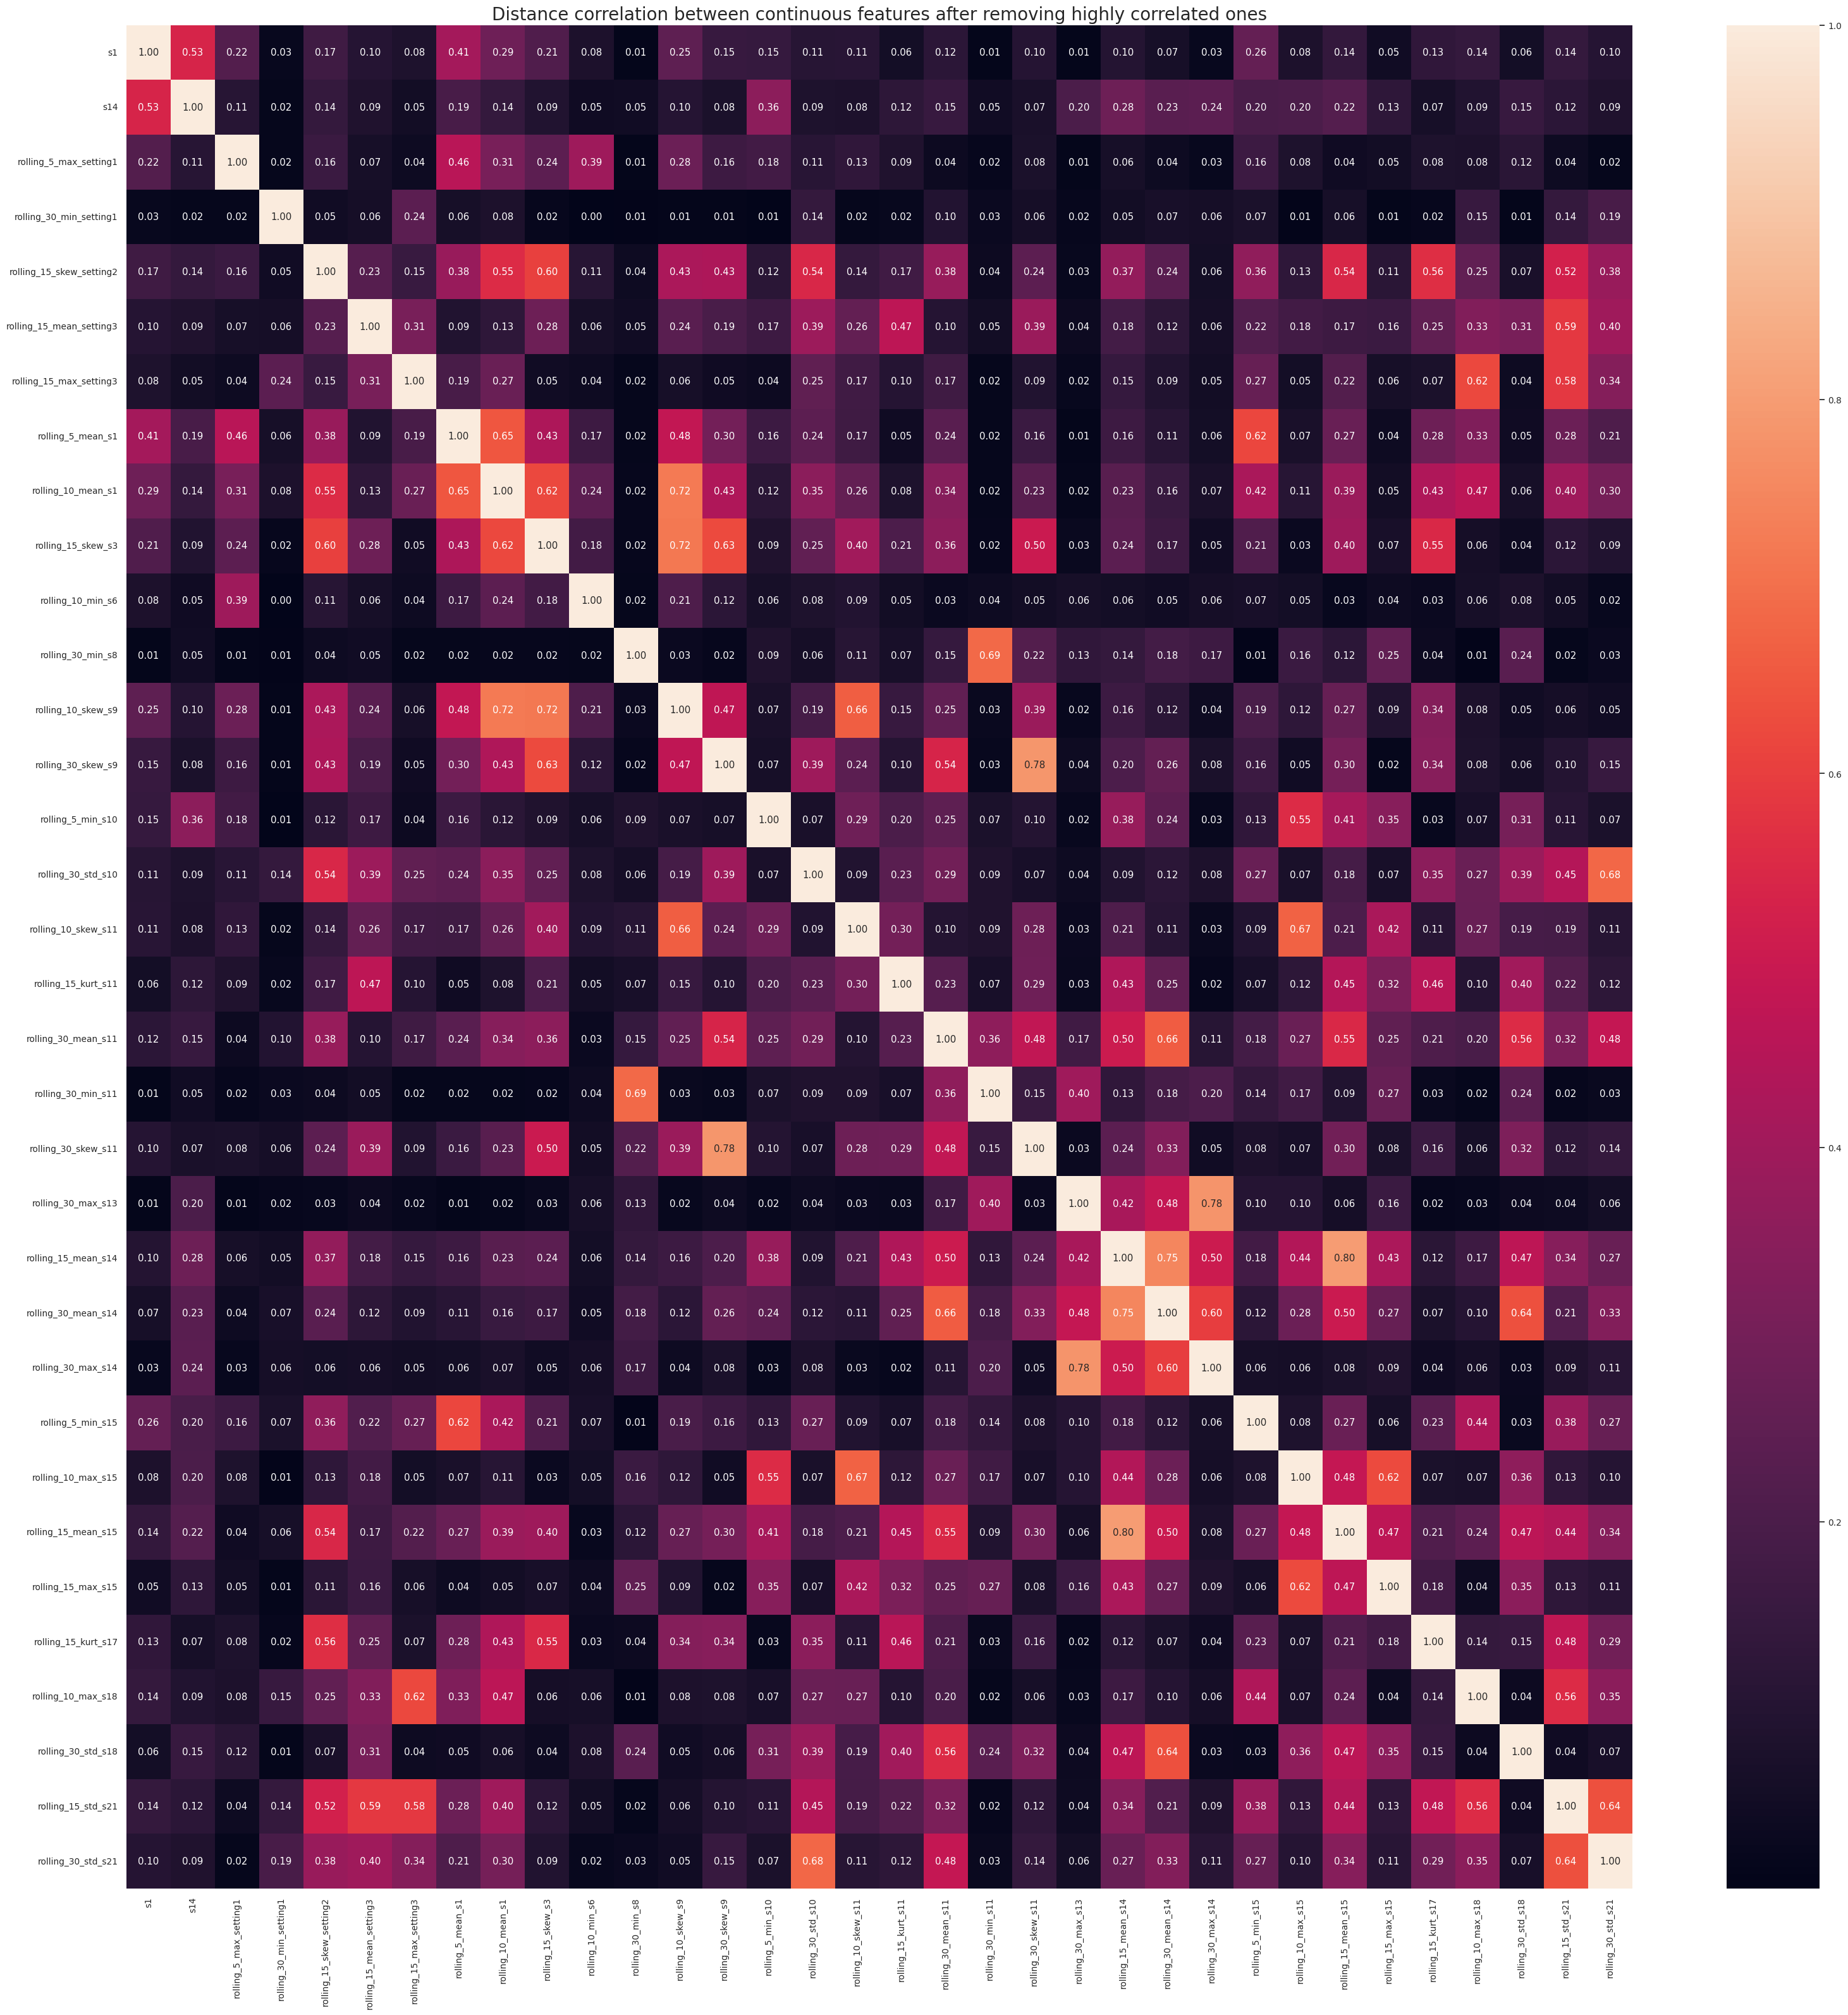

In [29]:
plt.figure(figsize = (32, 32))
sns.heatmap(corr_matrix_copy, annot = True, fmt = '.2f')
sns.set(font_scale = 0.9)
plt.title('Distance correlation between continuous features after removing highly correlated ones', size = 20)
plt.tight_layout()
#plt.savefig('Distance correlation between continuous features after removing highly correlated ones.png', dpi = 600)
plt.show()

In [30]:
#predictors = [col for col in rfe_selected_features if col not in hc]
predictors = ['work_cycle',
 's1',
 's14',
 'rolling_5_max_setting1',
 'rolling_30_min_setting1',
 'rolling_15_skew_setting2',
 'rolling_15_mean_setting3',
 'rolling_15_max_setting3',
 'rolling_5_mean_s1',
 'rolling_10_mean_s1',
 'rolling_15_skew_s3',
 'rolling_10_min_s6',
 'rolling_30_min_s8',
 'rolling_10_skew_s9',
 'rolling_30_skew_s9',
 'rolling_5_min_s10',
 'rolling_30_std_s10',
 'rolling_10_skew_s11',
 'rolling_15_kurt_s11',
 'rolling_30_mean_s11',
 'rolling_30_min_s11',
 'rolling_30_skew_s11',
 'rolling_30_max_s13',
 'rolling_15_mean_s14',
 'rolling_30_mean_s14',
 'rolling_30_max_s14',
 'rolling_5_min_s15',
 'rolling_10_max_s15',
 'rolling_15_mean_s15',
 'rolling_15_max_s15',
 'rolling_15_kurt_s17',
 'rolling_10_max_s18',
 'rolling_30_std_s18',
 'rolling_15_std_s21',
 'rolling_30_std_s21']

target = ['label']
unit_f = ['unit']
RUL_f = ['RUL']

In [31]:
len(predictors)

35

In [32]:
train_df = df[~df['unit'].isin(not_train)][unit_f + predictors + RUL_f + target].dropna(axis = 0).reset_index(drop = True)
val_df = df[df['unit'].isin(val_index)][unit_f + predictors + RUL_f + target].dropna(axis = 0).reset_index(drop = True)
test_df = df[df['unit'].isin(test_index)][unit_f + predictors + RUL_f + target].dropna(axis = 0).reset_index(drop = True)

In [33]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(29313, 38)
(5309, 38)
(4974, 38)


The code visualizes the distribution of the maximum work cycles (longevity) for each unit in the training dataset.

<Figure size 2500x1500 with 0 Axes>

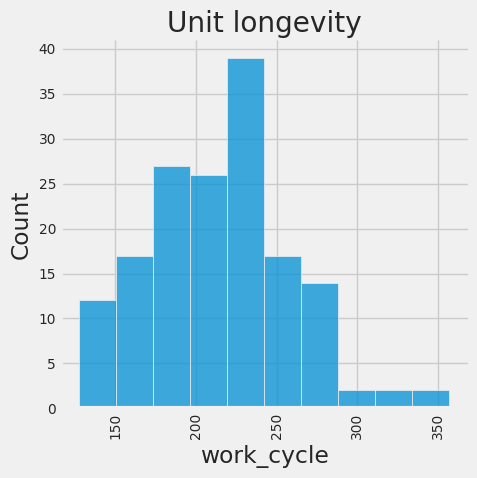

In [34]:
plt.figure(figsize = (25, 15))
plt.style.use('fivethirtyeight')
sns.displot(train_df.groupby('unit')['work_cycle'].max())
plt.title("Unit longevity")
plt.xticks(rotation = 90)
plt.tight_layout()
#plt.savefig('Unit longevity.png', dpi = 600)
plt.show()

In [35]:
print("medium working time:", train_df.unit.value_counts().mean())
print("max working time:", train_df.unit.value_counts().max())
print("min working time:", train_df.unit.value_counts().min())

medium working time: 185.5253164556962
max working time: 328
min working time: 99


This step helps in exploring and understanding the behavior of various predictors over time for a specific unit, which is crucial for diagnosing issues and building predictive models.

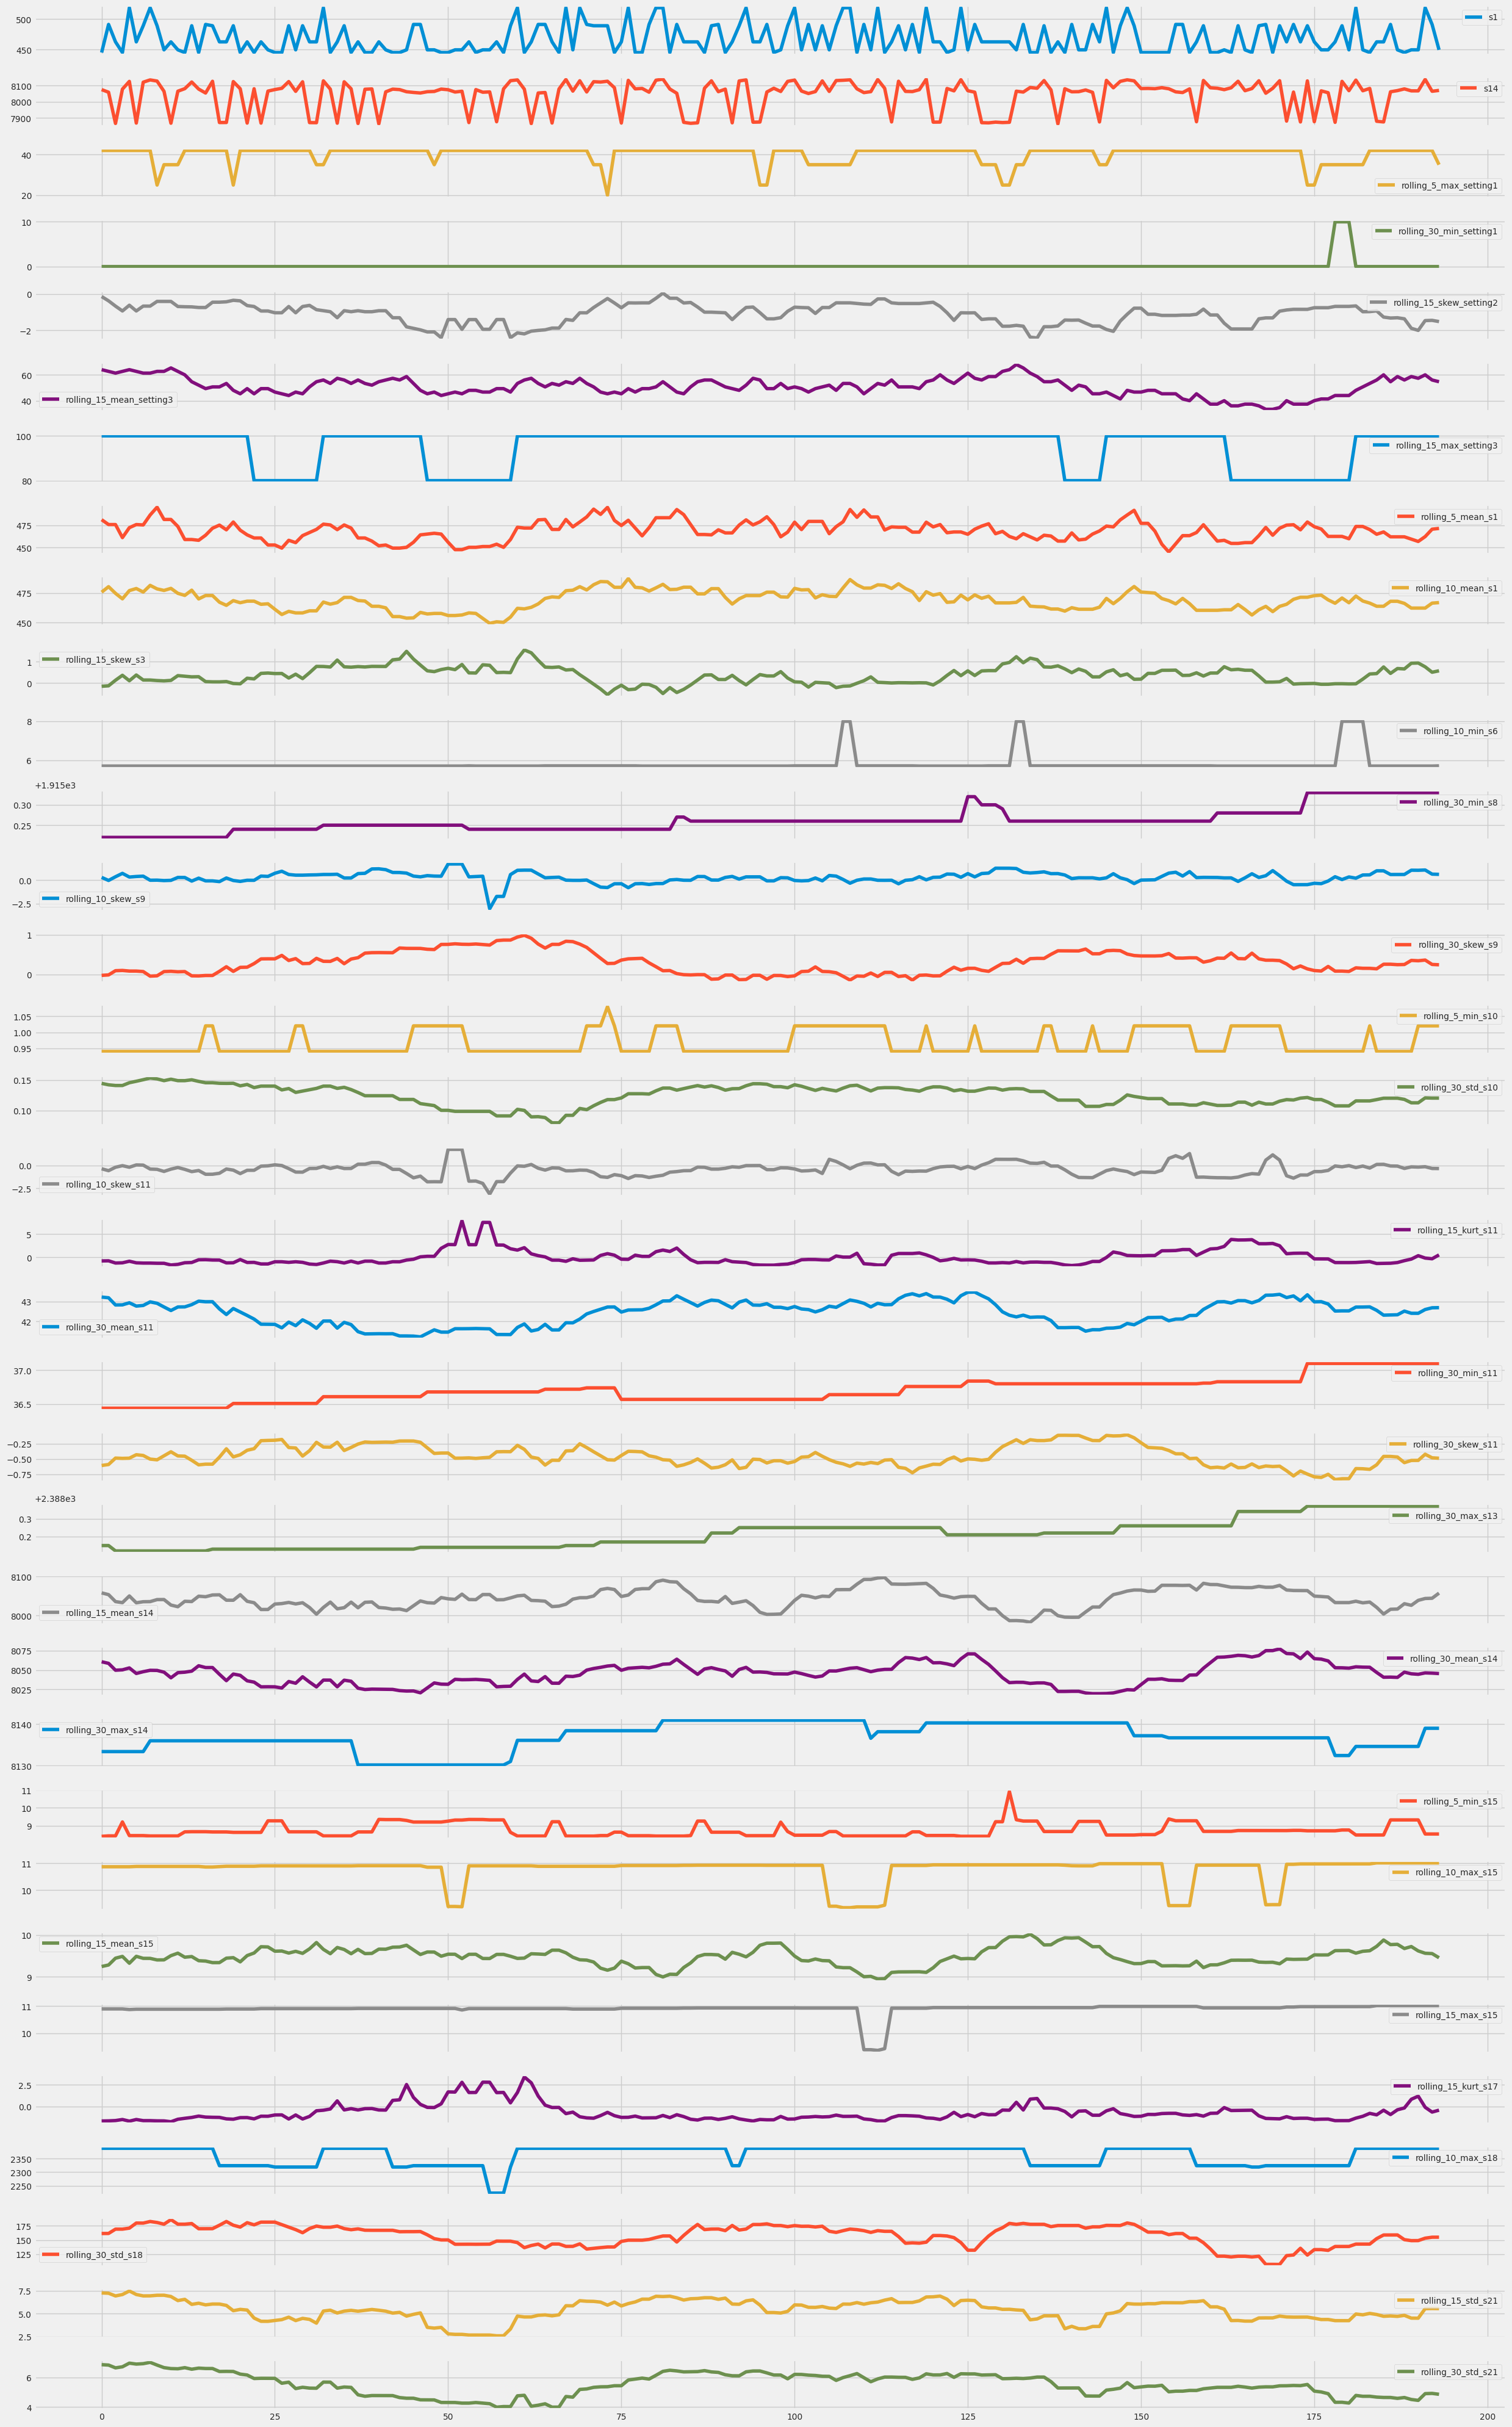

In [36]:
unit_number = train_df[train_df['unit'] == 1]
unit_number[predictors[1:]].plot(subplots = True, sharex = True, figsize = (25, 40));
plt.tight_layout()
#plt.savefig('Time series.png', dpi = 600)
plt.show()

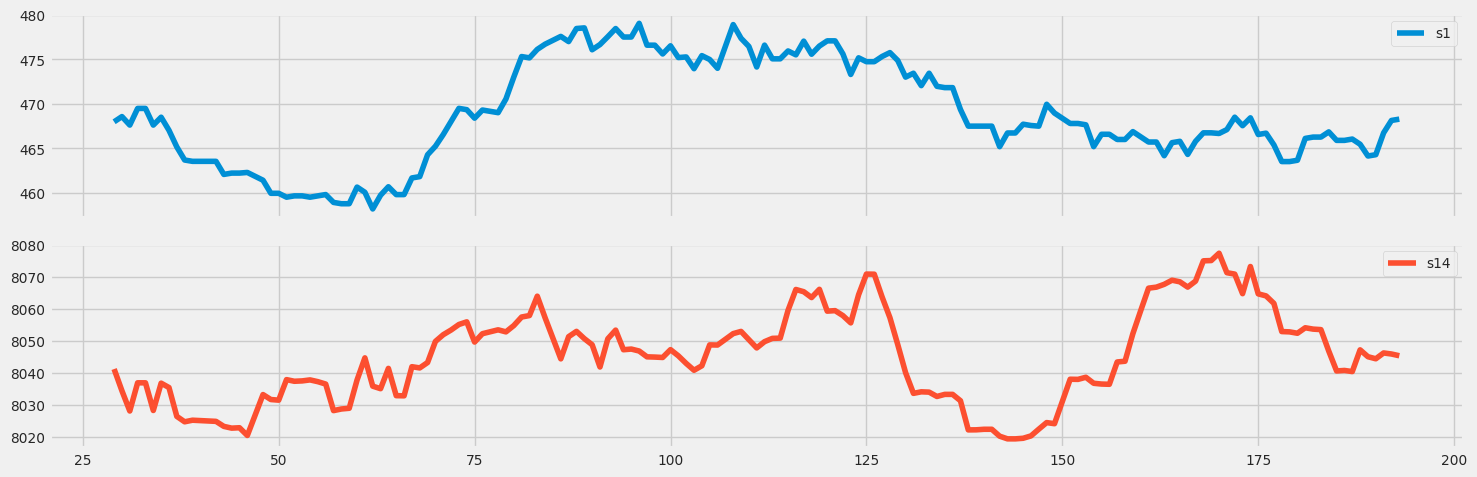

In [37]:
unit_number[predictors[1:3]].rolling(30).mean().plot(subplots = True, sharex = True, figsize = (15, 5));
plt.tight_layout()
#plt.savefig('Time series 2.png', dpi = 600)
plt.show()

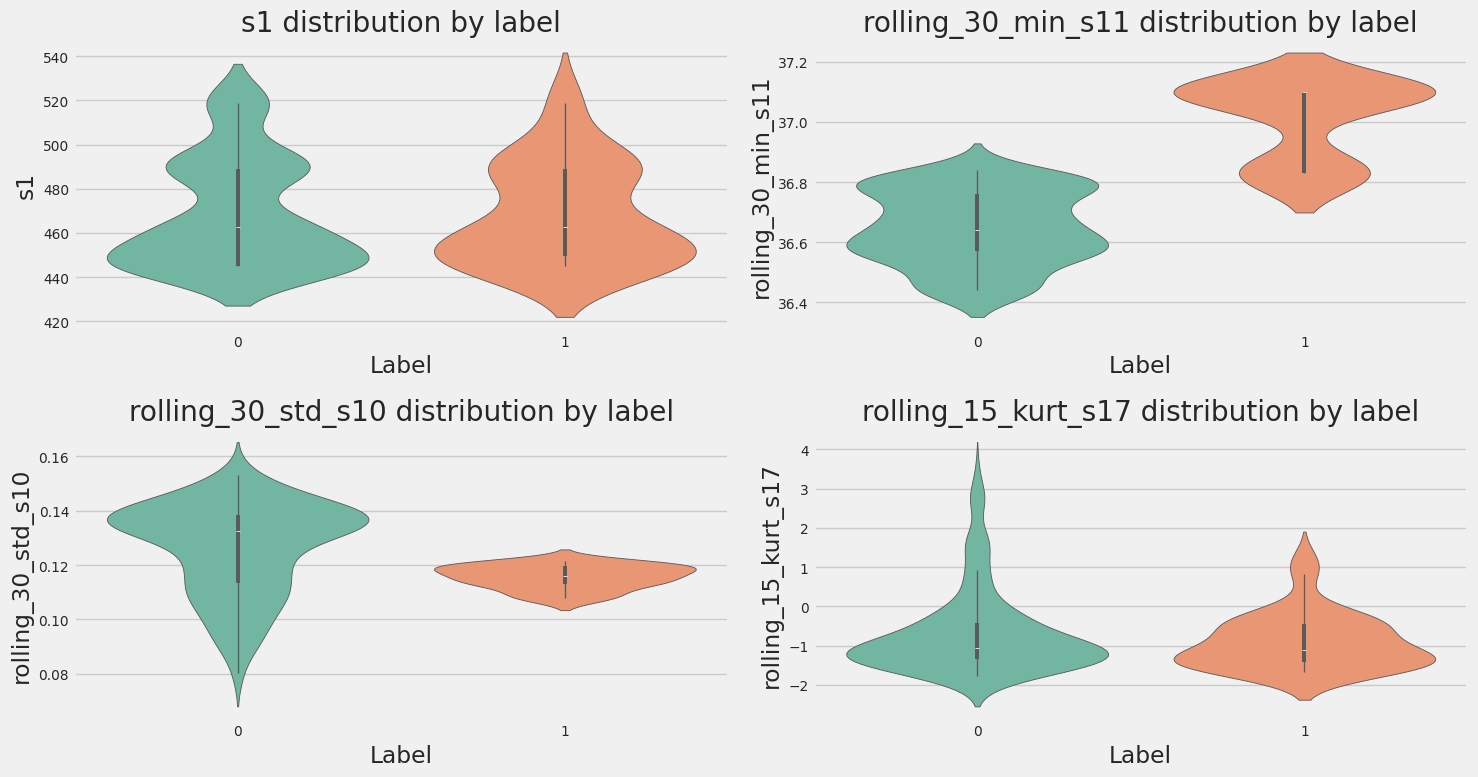

In [38]:
f1 = "s1"
f2 = "rolling_30_min_s11"
f3 = "rolling_30_std_s10"
f4 = "rolling_15_kurt_s17"

fig, axes = plt.subplots(2, 2, figsize = (15, 8))

sns.violinplot(x = "label", y = f1, data = unit_number, palette = "Set2", ax = axes[0, 0])
sns.violinplot(x = "label", y = f2, data = unit_number, palette = "Set2", ax = axes[0, 1])
sns.violinplot(x = "label", y = f3, data = unit_number, palette = "Set2", ax = axes[1, 0])
sns.violinplot(x = "label", y = f4, data = unit_number, palette = "Set2", ax = axes[1, 1])

axes[0, 0].set_title(f"{f1} distribution by label")
axes[0, 0].set_xlabel("Label")
axes[0, 0].set_ylabel(f1)
axes[0, 1].set_title(f"{f2} distribution by label")
axes[0, 1].set_xlabel("Label")
axes[0, 1].set_ylabel(f2)
axes[1, 0].set_title(f"{f3} distribution by label")
axes[1, 0].set_xlabel("Label")
axes[1, 0].set_ylabel(f3)
axes[1, 1].set_title(f"{f4} distribution by label")
axes[1, 1].set_xlabel("Label")
axes[1, 1].set_ylabel(f4)

plt.tight_layout()
#plt.savefig('Feature distributions by label.png', dpi = 600)
plt.show()

In this section, we are randomly sampling a subset of units from the training dataset for memory reasons.

In [39]:
np.random.seed(999)
sampler = np.random.choice(train_df['unit'].unique(), 60, replace = False)

In [40]:
full_train_df = train_df.copy()

In [41]:
train_df = full_train_df[full_train_df['unit'].isin(sampler)].reset_index(drop = True)

In [42]:
unit_1_length = len(train_df[train_df['unit'] == 1])

In [43]:
scaler = MinMaxScaler()

train_df[predictors] = scaler.fit_transform(train_df[predictors])
val_df[predictors] = scaler.transform(val_df[predictors])
test_df[predictors] = scaler.transform(test_df[predictors])

#CNN data preparation

The code generates sequences and corresponding labels for training, validation, and testing datasets by extracting sequences of a specified length and their associated labels from the dataframes. It handles each unit separately to maintain the time series nature of the data. The sequences and labels are then converted to NumPy arrays.

In [44]:
def gen_sequence(df, seq_length, seq_cols):

    data_matrix = df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements+1)):
      yield data_matrix[start:stop, :]

def gen_labels(df, seq_length, label):

    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements+1, :]

In [45]:
sequence_length = 50

In [46]:
x_train, x_val, x_test = [], [], []

for unit in train_df.unit.unique():
    for sequence in gen_sequence(train_df[train_df.unit == unit], sequence_length, predictors):
        x_train.append(sequence)

for unit in val_df.unit.unique():
    for sequence in gen_sequence(val_df[val_df.unit == unit], sequence_length, predictors):
        x_val.append(sequence)

for unit in test_df.unit.unique():
    for sequence in gen_sequence(test_df[test_df.unit == unit], sequence_length, predictors):
        x_test.append(sequence)

x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)

In [47]:
print("X_Train shape:", x_train.shape)
print("X_Val shape:", x_val.shape)
print("X_Test shape:", x_test.shape)

X_Train shape: (8816, 50, 35)
X_Val shape: (3809, 50, 35)
X_Test shape: (3474, 50, 35)


In [48]:
y_train, y_val, y_test = [], [], []

for unit in train_df.unit.unique():
    for label in gen_labels(train_df[train_df.unit == unit], sequence_length, ['label']):
        y_train.append(label)

for unit in val_df.unit.unique():
    for label in gen_labels(val_df[val_df.unit == unit], sequence_length, ['label']):
        y_val.append(label)

for unit in test_df.unit.unique():
    for label in gen_labels(test_df[test_df.unit == unit], sequence_length, ['label']):
        y_test.append(label)

y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

In [49]:
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

y_train shape: (8816, 1)
y_val shape: (3809, 1)
y_test shape: (3474, 1)


In [50]:
unit_1_length

194

Sanity check.
After dropping NaN rows from the DataFrame, unit 1 has 194 work cycles.
Given that we chose a sequence length of 50, there should be 144 sequences of length 50 each for unit 1.
30 sequences belong to class 1, and the rest belong to class 0.

In [53]:
Counter(y_train[:unit_1_length-sequence_length].ravel())

Counter({0: 114, 1: 30})

The code generates recurrence plots for the sequences of each predictor in the training dataset and converts these plots into images. Recurrence plots provide visual insights into the temporal dynamics of the data, which can be useful for understanding patterns and structures in the time series. Converting the sequences to images allows us to leverage image-based approaches for further analysis or modeling.

In [54]:
def rec_plot(s, eps = 0.10, steps = 10):
    d = pdist(s[:, None])
    d = np.floor(d / eps)
    d[d > steps] = steps
    Z = squareform(d)
    Z = (Z - np.min(Z)) / (np.max(Z) - np.min(Z) + 1e-10)
    return Z

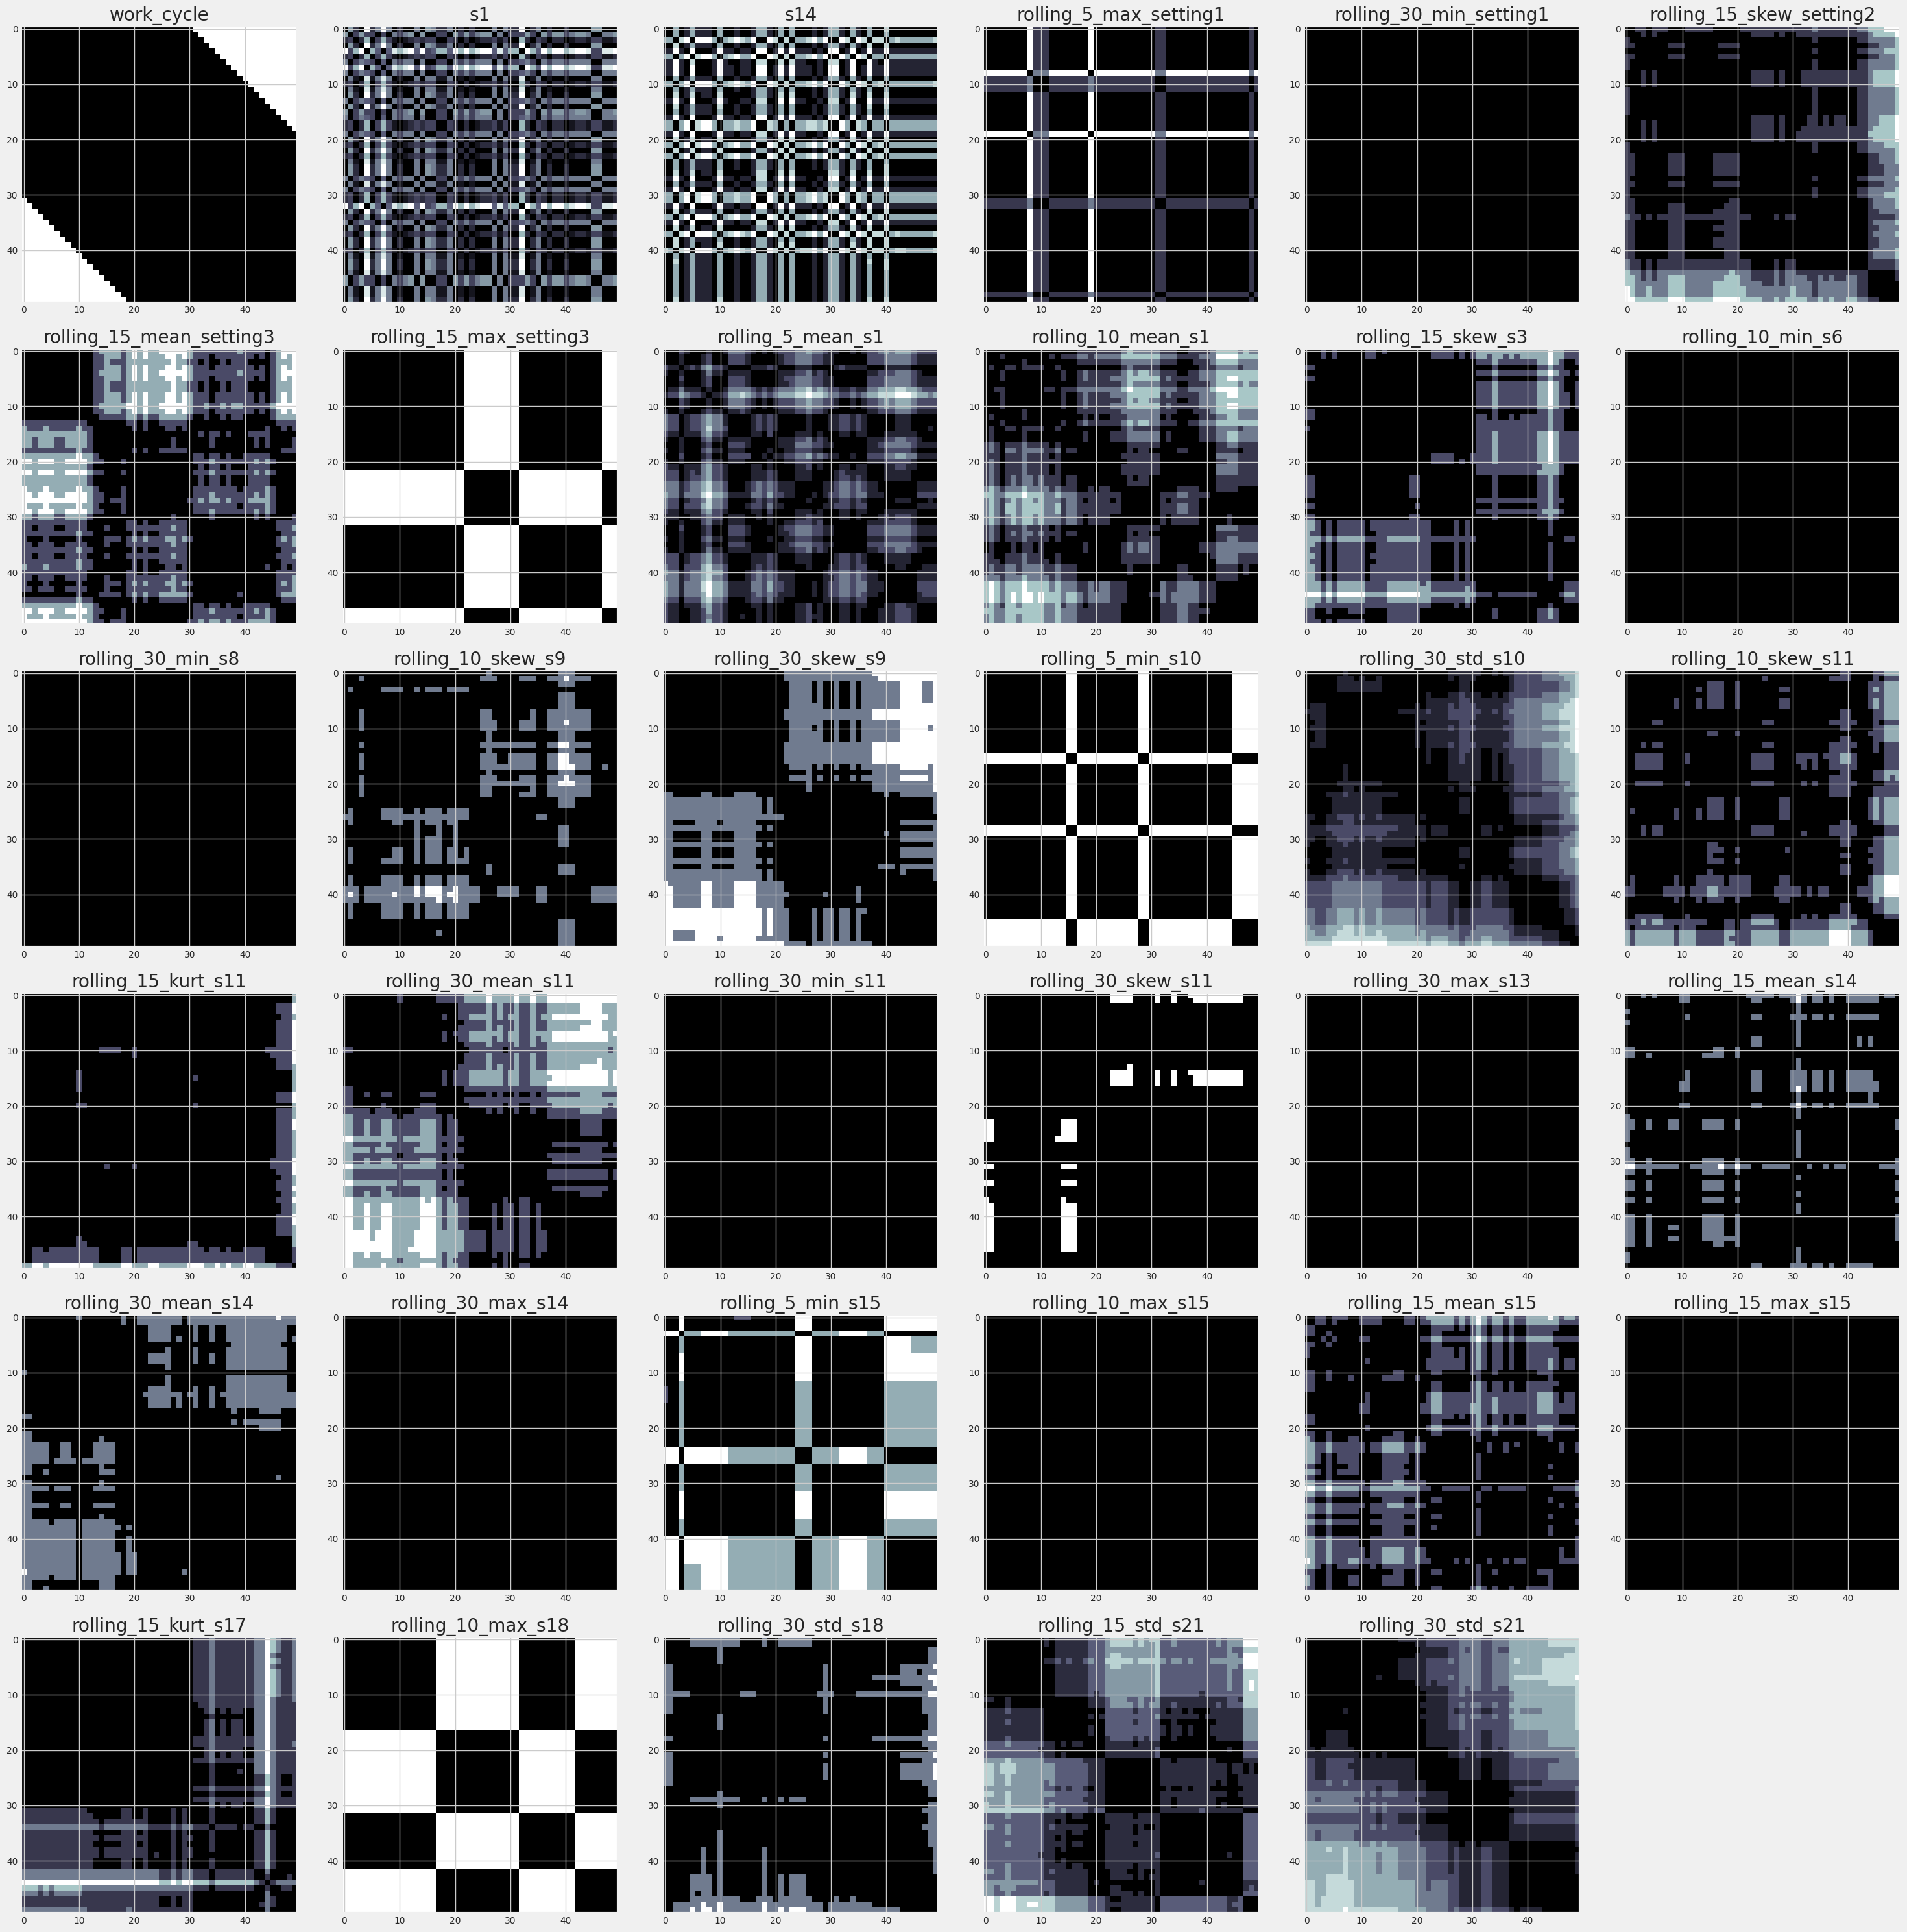

In [55]:
plt.figure(figsize = (30, 30))
for i in range(0, len(predictors)):

    plt.subplot(6, 6, i + 1)
    rec = rec_plot(x_train[0,:,i])
    plt.imshow(rec, cmap = 'bone')
    plt.title(predictors[i])

plt.tight_layout()
#plt.savefig('Images.png', dpi = 600)
plt.show()

In [56]:
x_train_img = np.apply_along_axis(rec_plot, 1, x_train).astype('float32')
x_val_img = np.apply_along_axis(rec_plot, 1, x_val).astype('float32')
x_test_img = np.apply_along_axis(rec_plot, 1, x_test).astype('float32')

In [57]:
print(x_train_img.shape)
print(x_val_img.shape)
print(x_test_img.shape)

(8816, 50, 50, 35)
(3809, 50, 50, 35)
(3474, 50, 50, 35)


Convert the numpy arrays to PyTorch tensors.

In [58]:
train_images = torch.from_numpy(x_train_img)
train_labels = torch.from_numpy(y_train)

val_images = torch.from_numpy(x_val_img)
val_labels = torch.from_numpy(y_val)

test_images = torch.from_numpy(x_test_img)
test_labels = torch.from_numpy(y_test)

In [59]:
train_images = train_images.permute(0, 3, 1, 2)
val_images = val_images.permute(0, 3, 1, 2)
test_images = test_images.permute(0, 3, 1, 2)

In [60]:
train_labels = train_labels.squeeze(1)
val_labels = val_labels.squeeze(1)
test_labels = test_labels.squeeze(1)

This code encapsulates the data loading process for training, validation, and testing by defining a custom dataset class and creating data loaders using PyTorch's utility functions.

In [61]:
class PMDataset(Dataset):
    def __init__(self, images, labels, transform = None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if self.transform is not None:
          image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.images)

In [62]:
BATCH_SIZE = 128

In [63]:
train_data = PMDataset(train_images, train_labels)
val_data = PMDataset(val_images, val_labels)
test_data = PMDataset(test_images, test_labels)

In [64]:
train_iterator = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
valid_iterator = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = True)
test_iterator = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True)

In [65]:
tr_im, tr_lbl = next(iter(train_iterator))

In [66]:
tr_im.shape

torch.Size([128, 35, 50, 50])

In [67]:
tr_lbl.shape

torch.Size([128])

#CNN

The code fetches the settings for the Xception model and then initializes an instance of the Xception model pre-trained on the ImageNet dataset using the pretrainedmodels library.

In [68]:
pretrainedmodels.pretrained_settings['xception']

{'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth',
  'input_space': 'RGB',
  'input_size': [3, 299, 299],
  'input_range': [0, 1],
  'mean': [0.5, 0.5, 0.5],
  'std': [0.5, 0.5, 0.5],
  'num_classes': 1000,
  'scale': 0.8975}}

In [69]:
xception_model = pretrainedmodels.__dict__['xception'](num_classes = 1000, pretrained = 'imagenet')

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
100%|██████████| 87.4M/87.4M [04:17<00:00, 356kB/s]


In [70]:
IN_CHANNELS = len(predictors)
OUTPUT_DIM = 1

The code customizes the architecture of the Xception model by replacing the first convolutional layer and modifying the last linear layer. It also initializes the weights of the added layers and freezes the parameters of the rest of the model. It is used to fine-tune the Xception model for a specific task while keeping the pre-trained weights fixed for most layers.

In [71]:
xception_model.conv1 = nn.Conv2d(IN_CHANNELS, 32, kernel_size = (3, 3), stride = (2, 2), bias = False)

In [72]:
in_features = xception_model.last_linear.in_features

xception_model.last_linear = nn.Sequential(nn.Linear(in_features, 256),
                                  nn.ReLU(),
                                  nn.BatchNorm1d(256, affine = True),
                                  nn.Dropout(p = 0.1),
                                  nn.Linear(256, 64),
                                  nn.LeakyReLU(),
                                  nn.BatchNorm1d(64, affine = True),
                                  nn.Linear(64, OUTPUT_DIM)
                                  )

In [73]:
for param in xception_model.parameters():
    param.requires_grad = False

In [74]:
for param in xception_model.conv1.parameters():
  param.requires_grad = True

In [75]:
for param in xception_model.last_linear.parameters():
    param.requires_grad = True

In [76]:
nn.init.kaiming_normal_(xception_model.last_linear[0].weight.data, nonlinearity = 'relu')
nn.init.constant_(xception_model.last_linear[0].bias.data, 0)
nn.init.kaiming_normal_(xception_model.last_linear[4].weight.data, nonlinearity = 'leaky_relu')
nn.init.constant_(xception_model.last_linear[4].bias.data, 0)
nn.init.kaiming_normal_(xception_model.last_linear[7].weight.data, nonlinearity = 'linear')
nn.init.constant_(xception_model.last_linear[7].bias.data, 0)

tensor([0.])

In [77]:
sum(p.numel() for p in xception_model.parameters() if p.requires_grad)

551777

The pos_weight parameter is set to a tensor with a single value of 5.0, which assigns a higher weight to the positive class to address class imbalance.

In [87]:
FOUND_LR = 1e-3

optimizer = optim.AdamW(xception_model.parameters(), lr = FOUND_LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 3)
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([5.0]))

In [88]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [89]:
device

device(type='cuda')

In [90]:
xception_model = xception_model.to(device)
criterion = criterion.to(device)

The code below trains and evaluates the Xception model while monitoring key metrics such as loss, precision, and recall on both the training and validation datasets. It implements techniques such as model checkpointing and learning rate scheduling to improve training efficiency and performance.

In [91]:
def calculate_metrics(y_pred, y):
    top_pred = t_round(sigmoid(y_pred))
    prec = precision_score(y.detach().cpu().numpy(), top_pred.detach().cpu().numpy(), pos_label=1)
    rec = recall_score(y.detach().cpu().numpy(), top_pred.detach().cpu().numpy(), pos_label=1)
    metrics = (prec, rec)
    return metrics

In [92]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_prec = 0
    epoch_rec = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y.unsqueeze(1).float())

        metrics = calculate_metrics(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_prec += metrics[0]
        epoch_rec += metrics[1]

    return epoch_loss / len(iterator), epoch_prec / len(iterator), epoch_rec / len(iterator)

In [93]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_prec = 0
    epoch_rec = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y.unsqueeze(1).float())

            metrics = calculate_metrics(y_pred, y)

            epoch_loss += loss.item()
            epoch_prec += metrics[0]
            epoch_rec += metrics[1]

    return epoch_loss / len(iterator), epoch_prec / len(iterator), epoch_rec / len(iterator)

In [94]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [95]:
EPOCHS = 25

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_prec, train_rec = train(xception_model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_prec, valid_rec = evaluate(xception_model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(xception_model.state_dict(), f'gdrive/MyDrive/ML/projects/predictive-maintenance/xception-binary-target-30.pt')

    scheduler.step(valid_loss)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print()
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train precision for class 1: {train_prec:.2f} | Train recall for class 1: {train_rec:.2f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. precision for class 1: {valid_prec:.2f} | Val. recall for class 1: {valid_rec:.2f}')

Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 1.294 | Train precision for class 1: 0.21 | Train recall for class 1: 0.68
	 Val. Loss: 1.343 |  Val. precision for class 1: 0.24 | Val. recall for class 1: 0.80


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 1.239 | Train precision for class 1: 0.22 | Train recall for class 1: 0.76
	 Val. Loss: 1.385 |  Val. precision for class 1: 0.23 | Val. recall for class 1: 0.41


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 1.201 | Train precision for class 1: 0.24 | Train recall for class 1: 0.69
	 Val. Loss: 1.332 |  Val. precision for class 1: 0.25 | Val. recall for class 1: 0.55


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 1.184 | Train precision for class 1: 0.25 | Train recall for class 1: 0.64
	 Val. Loss: 1.361 |  Val. precision for class 1: 0.26 | Val. recall for class 1: 0.45


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 1.168 | Train precision for class 1: 0.27 | Train recall for class 1: 0.60
	 Val. Loss: 1.338 |  Val. precision for class 1: 0.27 | Val. recall for class 1: 0.44


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 1.133 | Train precision for class 1: 0.31 | Train recall for class 1: 0.58
	 Val. Loss: 1.331 |  Val. precision for class 1: 0.27 | Val. recall for class 1: 0.46


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 1.126 | Train precision for class 1: 0.31 | Train recall for class 1: 0.60
	 Val. Loss: 1.355 |  Val. precision for class 1: 0.24 | Val. recall for class 1: 0.64


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 1.148 | Train precision for class 1: 0.28 | Train recall for class 1: 0.59
	 Val. Loss: 1.334 |  Val. precision for class 1: 0.28 | Val. recall for class 1: 0.44


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 1.122 | Train precision for class 1: 0.31 | Train recall for class 1: 0.60
	 Val. Loss: 1.337 |  Val. precision for class 1: 0.27 | Val. recall for class 1: 0.40


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 10 | Epoch Time: 0m 11s
	Train Loss: 1.147 | Train precision for class 1: 0.29 | Train recall for class 1: 0.58
	 Val. Loss: 1.360 |  Val. precision for class 1: 0.26 | Val. recall for class 1: 0.37


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 11 | Epoch Time: 0m 10s
	Train Loss: 1.123 | Train precision for class 1: 0.30 | Train recall for class 1: 0.60
	 Val. Loss: 1.356 |  Val. precision for class 1: 0.26 | Val. recall for class 1: 0.38


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 12 | Epoch Time: 0m 10s
	Train Loss: 1.118 | Train precision for class 1: 0.30 | Train recall for class 1: 0.61
	 Val. Loss: 1.355 |  Val. precision for class 1: 0.25 | Val. recall for class 1: 0.39


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 13 | Epoch Time: 0m 11s
	Train Loss: 1.111 | Train precision for class 1: 0.30 | Train recall for class 1: 0.61
	 Val. Loss: 1.356 |  Val. precision for class 1: 0.25 | Val. recall for class 1: 0.36


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 14 | Epoch Time: 0m 11s
	Train Loss: 1.104 | Train precision for class 1: 0.31 | Train recall for class 1: 0.63
	 Val. Loss: 1.370 |  Val. precision for class 1: 0.25 | Val. recall for class 1: 0.37


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 15 | Epoch Time: 0m 11s
	Train Loss: 1.091 | Train precision for class 1: 0.31 | Train recall for class 1: 0.64
	 Val. Loss: 1.368 |  Val. precision for class 1: 0.26 | Val. recall for class 1: 0.36


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 16 | Epoch Time: 0m 10s
	Train Loss: 1.091 | Train precision for class 1: 0.32 | Train recall for class 1: 0.63
	 Val. Loss: 1.352 |  Val. precision for class 1: 0.26 | Val. recall for class 1: 0.38


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 17 | Epoch Time: 0m 11s
	Train Loss: 1.096 | Train precision for class 1: 0.31 | Train recall for class 1: 0.62
	 Val. Loss: 1.356 |  Val. precision for class 1: 0.25 | Val. recall for class 1: 0.36


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 18 | Epoch Time: 0m 11s
	Train Loss: 1.096 | Train precision for class 1: 0.32 | Train recall for class 1: 0.63
	 Val. Loss: 1.364 |  Val. precision for class 1: 0.25 | Val. recall for class 1: 0.39


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 19 | Epoch Time: 0m 11s
	Train Loss: 1.098 | Train precision for class 1: 0.32 | Train recall for class 1: 0.61
	 Val. Loss: 1.361 |  Val. precision for class 1: 0.26 | Val. recall for class 1: 0.38


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 20 | Epoch Time: 0m 11s
	Train Loss: 1.091 | Train precision for class 1: 0.32 | Train recall for class 1: 0.63
	 Val. Loss: 1.366 |  Val. precision for class 1: 0.25 | Val. recall for class 1: 0.36


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 21 | Epoch Time: 0m 10s
	Train Loss: 1.098 | Train precision for class 1: 0.32 | Train recall for class 1: 0.62
	 Val. Loss: 1.366 |  Val. precision for class 1: 0.26 | Val. recall for class 1: 0.35


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 22 | Epoch Time: 0m 11s
	Train Loss: 1.086 | Train precision for class 1: 0.32 | Train recall for class 1: 0.61
	 Val. Loss: 1.372 |  Val. precision for class 1: 0.26 | Val. recall for class 1: 0.35


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 23 | Epoch Time: 0m 11s
	Train Loss: 1.092 | Train precision for class 1: 0.31 | Train recall for class 1: 0.62
	 Val. Loss: 1.363 |  Val. precision for class 1: 0.25 | Val. recall for class 1: 0.39


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 24 | Epoch Time: 0m 11s
	Train Loss: 1.093 | Train precision for class 1: 0.32 | Train recall for class 1: 0.63
	 Val. Loss: 1.359 |  Val. precision for class 1: 0.27 | Val. recall for class 1: 0.39


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 25 | Epoch Time: 0m 11s
	Train Loss: 1.095 | Train precision for class 1: 0.31 | Train recall for class 1: 0.61
	 Val. Loss: 1.375 |  Val. precision for class 1: 0.26 | Val. recall for class 1: 0.36


In [105]:
def plot_loss(train_losses, val_losses, save_im = True, save_name = ''):
    # Create figure and axis
    fig, ax = plt.subplots()

    # Plot the loss curve
    ax.plot(train_losses, label='Train loss')
    ax.plot(val_losses, label='Val loss')

    # Set labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Loss')

    # Add gridlines
    ax.grid(True)

    # Add legend
    ax.legend()

    plt.tight_layout()

    if save_im:
      fig.savefig(save_name, dpi=600)

    # Show the plot
    plt.show()

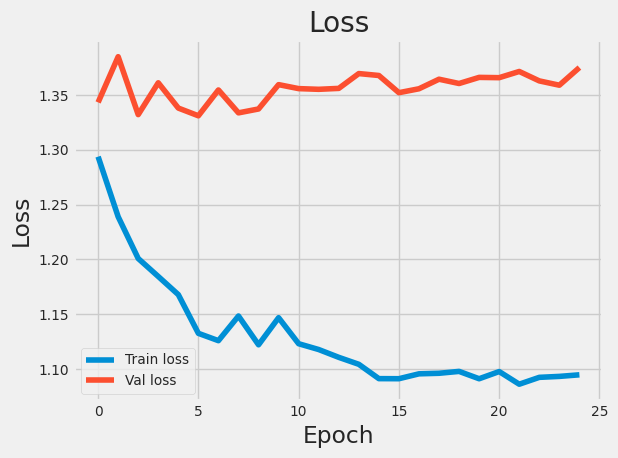

In [106]:
plot_loss(train_losses, valid_losses, False, save_name = 'Xception loss plot.png')

In [98]:
xception_model.load_state_dict(torch.load("gdrive/MyDrive/ML/projects/predictive-maintenance/xception-binary-target-30.pt"))

<All keys matched successfully>

In [99]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
xception_model = xception_model.to(device)

The provided code snippet evaluates the performance of the trained Xception model on the test dataset.

In [100]:
test_loss, test_prec, test_rec = evaluate(xception_model, test_iterator, criterion, device)

Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

In [101]:
test_loss

1.3848051130771637

In [102]:
test_prec

0.29709073436661715

In [103]:
test_rec

0.4871411869926122

In [107]:
def get_predictions(model, iterator, device):

    labels = []
    probs = []

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = sigmoid(y_pred)

            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return labels, probs

In [108]:
labels, probs = get_predictions(xception_model, test_iterator, device)

In [109]:
precision, recall, thresholds = precision_recall_curve(labels, probs)

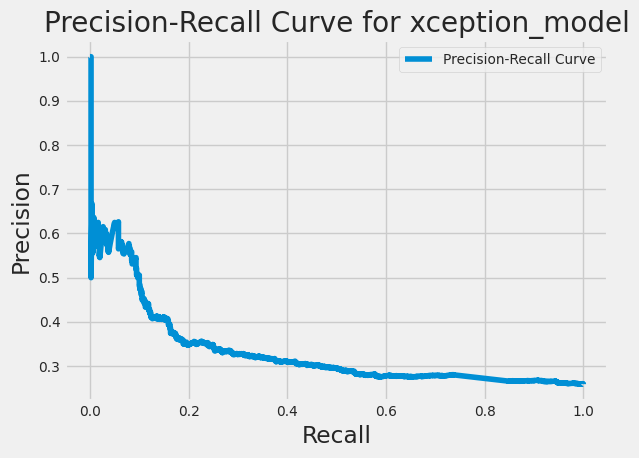

In [110]:
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for xception_model')
plt.legend()
plt.tight_layout()
#plt.savefig('Xception precision recall curve.png', dpi = 600)
plt.show()

In [111]:
pred_labels = t_round(probs).squeeze().long()

In [112]:
print(classification_report(labels.squeeze().numpy(), pred_labels.squeeze().numpy()))

              precision    recall  f1-score   support

           0       0.77      0.60      0.67      2574
           1       0.30      0.49      0.37       900

    accuracy                           0.57      3474
   macro avg       0.53      0.54      0.52      3474
weighted avg       0.65      0.57      0.59      3474



In [113]:
def plot_confusion_matrix(labels, pred_labels, classes, save_im = False, save_name = ''):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=0)

    if save_im:
      fig.savefig(save_name, dpi=600)

In [114]:
classes = [0, 1]

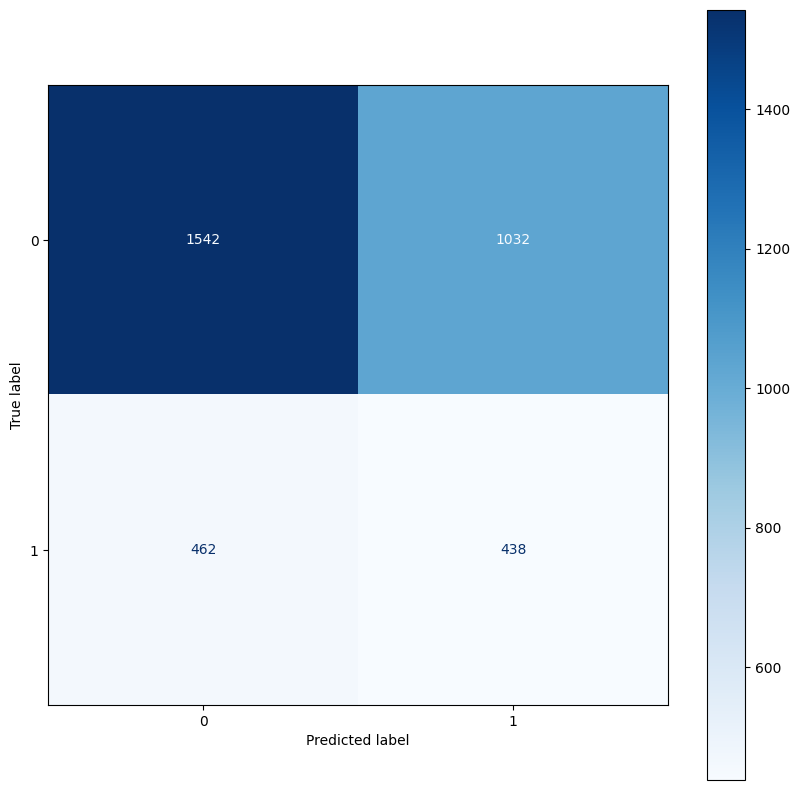

In [115]:
plt.style.use('default')
plot_confusion_matrix(labels, pred_labels, classes, save_im = False, save_name = 'Xception confusion matrix.png')

#KAN data preparation

The data for KAN is structured as 4D arrays representing grayscale "images" of size 1x1 with N channels, which is the number of features.

In [116]:
sequence_length = 1

In [117]:
x_train_img = train_df[predictors].to_numpy().reshape(-1, 1, 1, len(predictors)).astype('float32')
x_val_img = val_df[predictors].to_numpy().reshape(-1, 1, 1, len(predictors)).astype('float32')
x_test_img = test_df[predictors].to_numpy().reshape(-1, 1, 1, len(predictors)).astype('float32')

In [118]:
print(x_train_img.shape)
print(x_val_img.shape)
print(x_test_img.shape)

(11816, 1, 1, 35)
(5309, 1, 1, 35)
(4974, 1, 1, 35)


In [119]:
y_train = train_df['label'].values.reshape(-1, 1)
y_val = val_df['label'].values.reshape(-1, 1)
y_test = test_df['label'].values.reshape(-1, 1)

In [120]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(11816, 1)
(5309, 1)
(4974, 1)


In [121]:
train_images = torch.from_numpy(x_train_img)
train_labels = torch.from_numpy(y_train)

val_images = torch.from_numpy(x_val_img)
val_labels = torch.from_numpy(y_val)

test_images = torch.from_numpy(x_test_img)
test_labels = torch.from_numpy(y_test)

In [122]:
train_images = train_images.permute(0, 3, 1, 2)
val_images = val_images.permute(0, 3, 1, 2)
test_images = test_images.permute(0, 3, 1, 2)

In [123]:
train_labels = train_labels.squeeze(1)
val_labels = val_labels.squeeze(1)
test_labels = test_labels.squeeze(1)

In [124]:
class PMDataset(Dataset):
    def __init__(self, images, labels, transform = None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if self.transform is not None:
          image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.images)

In [125]:
BATCH_SIZE = 128

In [126]:
train_data = PMDataset(train_images, train_labels)
val_data = PMDataset(val_images, val_labels)
test_data = PMDataset(test_images, test_labels)

In [127]:
train_iterator = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
valid_iterator = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = True)
test_iterator = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True)

In [128]:
tr_im, tr_lbl = next(iter(train_iterator))

In [129]:
tr_im.shape

torch.Size([128, 35, 1, 1])

In [130]:
tr_lbl.shape

torch.Size([128])

#KAN

Below is an implementation of a Kolmogorov-Arnold Network.  

In [131]:
#credit: https://github.com/Blealtan/efficient-kan/blob/master/examples/mnist.py

class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [132]:
IN_CHANNELS = len(predictors)
OUTPUT_DIM = 1

The code сreates a neural network model using the KAN class with a specific architecture and activation function. It defines a fully connected architecture and specifies the Hardswish activation function for the base layer.

In [133]:
model = KAN([sequence_length * sequence_length * IN_CHANNELS, 32, OUTPUT_DIM], base_activation = torch.nn.Hardswish)

In [134]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

11520

The code defines a custom optimizer named LARS (Layer-wise Adaptive Rate Scaling), which was tested during model training alongside AdamW. While AdamW produced better results in terms of loss and metrics, LARS also demonstrated stable training.

In [135]:
class LARS(optim.Optimizer):
    def __init__(self, params, lr = 1e-3, momentum = 0.9, weight_decay = 1e-4, eps = 1e-8):
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay, eps=eps)
        super(LARS, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('LARS does not support sparse gradients')

                weight_norm = torch.norm(p.data)
                grad_norm = torch.norm(grad)
                if weight_norm == 0 or grad_norm == 0:
                    continue

                local_lr = group['lr'] * weight_norm / (grad_norm + group['weight_decay'] * weight_norm + group['eps'])
                p.data.add_(grad, alpha=-local_lr)

                if group['weight_decay'] != 0:
                    p.data.add_(p.data, alpha=-group['weight_decay'] * local_lr)

        return loss

In [136]:
optimizer = optim.AdamW(model.parameters(), lr = 1e-3, weight_decay = 1e-4)
#optimizer = LARS(model.parameters(), lr = 1e-3, weight_decay = 1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 3)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.8)
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([5.0]))

In [137]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [138]:
device

device(type='cuda')

In [139]:
model = model.to(device)
criterion = criterion.to(device)

The code encapsulates the training process of the KAN model. It iterates over a specified number of epochs, updating the model parameters based on the training data and evaluating its performance on the validation data. It also adjusts the learning rate using a learning rate scheduler and saves the best model based on the validation loss.

In [140]:
def calculate_metrics(y_pred, y):
    top_pred = t_round(sigmoid(y_pred))
    prec = precision_score(y.detach().cpu().numpy(), top_pred.detach().cpu().numpy(), pos_label=1)
    rec = recall_score(y.detach().cpu().numpy(), top_pred.detach().cpu().numpy(), pos_label=1)
    metrics = (prec, rec)
    return metrics

In [141]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_prec = 0
    epoch_rec = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.view(-1, sequence_length * sequence_length * IN_CHANNELS).to(device)

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y.unsqueeze(1).float())

        metrics = calculate_metrics(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_prec += metrics[0]
        epoch_rec += metrics[1]

    return epoch_loss / len(iterator), epoch_prec / len(iterator), epoch_rec / len(iterator)

In [142]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_prec = 0
    epoch_rec = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.view(-1, sequence_length * sequence_length * IN_CHANNELS).to(device)

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y.unsqueeze(1).float())

            metrics = calculate_metrics(y_pred, y)

            epoch_loss += loss.item()
            epoch_prec += metrics[0]
            epoch_rec += metrics[1]

    return epoch_loss / len(iterator), epoch_prec / len(iterator), epoch_rec / len(iterator)

In [143]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [144]:
EPOCHS = 35

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_prec, train_rec = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_prec, valid_rec = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f'gdrive/MyDrive/ML/projects/predictive-maintenance/kan-binary-target-30.pt')

    #scheduler.step()
    scheduler.step(valid_loss)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print()
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train precision for class 1: {train_prec:.2f} | Train recall for class 1: {train_rec:.2f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. precision for class 1: {valid_prec:.2f} | Val. recall for class 1: {valid_rec:.2f}')

Epochs:   0%|          | 0/35 [00:00<?, ?it/s]

Training:   0%|          | 0/93 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 1.081 | Train precision for class 1: 0.53 | Train recall for class 1: 0.35
	 Val. Loss: 1.095 |  Val. precision for class 1: 0.55 | Val. recall for class 1: 0.27


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.829 | Train precision for class 1: 0.51 | Train recall for class 1: 0.72
	 Val. Loss: 0.796 |  Val. precision for class 1: 0.61 | Val. recall for class 1: 0.62


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.567 | Train precision for class 1: 0.50 | Train recall for class 1: 0.84
	 Val. Loss: 0.781 |  Val. precision for class 1: 0.68 | Val. recall for class 1: 0.58


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.500 | Train precision for class 1: 0.52 | Train recall for class 1: 0.88
	 Val. Loss: 0.631 |  Val. precision for class 1: 0.69 | Val. recall for class 1: 0.76


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.453 | Train precision for class 1: 0.55 | Train recall for class 1: 0.89
	 Val. Loss: 0.515 |  Val. precision for class 1: 0.64 | Val. recall for class 1: 0.82


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.417 | Train precision for class 1: 0.57 | Train recall for class 1: 0.90
	 Val. Loss: 0.465 |  Val. precision for class 1: 0.64 | Val. recall for class 1: 0.85


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 0.377 | Train precision for class 1: 0.60 | Train recall for class 1: 0.91
	 Val. Loss: 0.420 |  Val. precision for class 1: 0.65 | Val. recall for class 1: 0.89


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 0.348 | Train precision for class 1: 0.62 | Train recall for class 1: 0.92
	 Val. Loss: 0.415 |  Val. precision for class 1: 0.69 | Val. recall for class 1: 0.87


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 0.328 | Train precision for class 1: 0.64 | Train recall for class 1: 0.92
	 Val. Loss: 0.383 |  Val. precision for class 1: 0.66 | Val. recall for class 1: 0.90


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 10 | Epoch Time: 0m 1s
	Train Loss: 0.314 | Train precision for class 1: 0.66 | Train recall for class 1: 0.92
	 Val. Loss: 0.389 |  Val. precision for class 1: 0.55 | Val. recall for class 1: 0.96


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 11 | Epoch Time: 0m 1s
	Train Loss: 0.306 | Train precision for class 1: 0.67 | Train recall for class 1: 0.92
	 Val. Loss: 0.397 |  Val. precision for class 1: 0.53 | Val. recall for class 1: 0.96


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 12 | Epoch Time: 0m 1s
	Train Loss: 0.291 | Train precision for class 1: 0.67 | Train recall for class 1: 0.93
	 Val. Loss: 0.362 |  Val. precision for class 1: 0.69 | Val. recall for class 1: 0.90


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 13 | Epoch Time: 0m 1s
	Train Loss: 0.281 | Train precision for class 1: 0.68 | Train recall for class 1: 0.93
	 Val. Loss: 0.395 |  Val. precision for class 1: 0.73 | Val. recall for class 1: 0.86


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 14 | Epoch Time: 0m 1s
	Train Loss: 0.277 | Train precision for class 1: 0.68 | Train recall for class 1: 0.93
	 Val. Loss: 0.356 |  Val. precision for class 1: 0.68 | Val. recall for class 1: 0.91


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 15 | Epoch Time: 0m 1s
	Train Loss: 0.273 | Train precision for class 1: 0.69 | Train recall for class 1: 0.94
	 Val. Loss: 0.361 |  Val. precision for class 1: 0.70 | Val. recall for class 1: 0.89


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 16 | Epoch Time: 0m 1s
	Train Loss: 0.265 | Train precision for class 1: 0.69 | Train recall for class 1: 0.94
	 Val. Loss: 0.366 |  Val. precision for class 1: 0.72 | Val. recall for class 1: 0.89


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 17 | Epoch Time: 0m 1s
	Train Loss: 0.263 | Train precision for class 1: 0.70 | Train recall for class 1: 0.94
	 Val. Loss: 0.410 |  Val. precision for class 1: 0.77 | Val. recall for class 1: 0.84


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 18 | Epoch Time: 0m 1s
	Train Loss: 0.260 | Train precision for class 1: 0.71 | Train recall for class 1: 0.93
	 Val. Loss: 0.347 |  Val. precision for class 1: 0.67 | Val. recall for class 1: 0.92


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 19 | Epoch Time: 0m 1s
	Train Loss: 0.253 | Train precision for class 1: 0.71 | Train recall for class 1: 0.94
	 Val. Loss: 0.357 |  Val. precision for class 1: 0.69 | Val. recall for class 1: 0.91


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 20 | Epoch Time: 0m 1s
	Train Loss: 0.246 | Train precision for class 1: 0.71 | Train recall for class 1: 0.95
	 Val. Loss: 0.370 |  Val. precision for class 1: 0.69 | Val. recall for class 1: 0.88


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 21 | Epoch Time: 0m 1s
	Train Loss: 0.249 | Train precision for class 1: 0.71 | Train recall for class 1: 0.94
	 Val. Loss: 0.408 |  Val. precision for class 1: 0.77 | Val. recall for class 1: 0.84


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 22 | Epoch Time: 0m 1s
	Train Loss: 0.243 | Train precision for class 1: 0.71 | Train recall for class 1: 0.95
	 Val. Loss: 0.409 |  Val. precision for class 1: 0.76 | Val. recall for class 1: 0.83


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 23 | Epoch Time: 0m 1s
	Train Loss: 0.238 | Train precision for class 1: 0.74 | Train recall for class 1: 0.94
	 Val. Loss: 0.348 |  Val. precision for class 1: 0.64 | Val. recall for class 1: 0.92


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 24 | Epoch Time: 0m 1s
	Train Loss: 0.237 | Train precision for class 1: 0.72 | Train recall for class 1: 0.94
	 Val. Loss: 0.362 |  Val. precision for class 1: 0.69 | Val. recall for class 1: 0.89


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 25 | Epoch Time: 0m 1s
	Train Loss: 0.232 | Train precision for class 1: 0.72 | Train recall for class 1: 0.95
	 Val. Loss: 0.364 |  Val. precision for class 1: 0.69 | Val. recall for class 1: 0.89


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 26 | Epoch Time: 0m 1s
	Train Loss: 0.233 | Train precision for class 1: 0.73 | Train recall for class 1: 0.95
	 Val. Loss: 0.356 |  Val. precision for class 1: 0.69 | Val. recall for class 1: 0.90


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 27 | Epoch Time: 0m 1s
	Train Loss: 0.234 | Train precision for class 1: 0.73 | Train recall for class 1: 0.95
	 Val. Loss: 0.354 |  Val. precision for class 1: 0.68 | Val. recall for class 1: 0.91


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 28 | Epoch Time: 0m 1s
	Train Loss: 0.232 | Train precision for class 1: 0.73 | Train recall for class 1: 0.95
	 Val. Loss: 0.353 |  Val. precision for class 1: 0.69 | Val. recall for class 1: 0.91


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 29 | Epoch Time: 0m 1s
	Train Loss: 0.231 | Train precision for class 1: 0.73 | Train recall for class 1: 0.95
	 Val. Loss: 0.356 |  Val. precision for class 1: 0.68 | Val. recall for class 1: 0.91


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 30 | Epoch Time: 0m 1s
	Train Loss: 0.233 | Train precision for class 1: 0.73 | Train recall for class 1: 0.95
	 Val. Loss: 0.353 |  Val. precision for class 1: 0.68 | Val. recall for class 1: 0.91


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 31 | Epoch Time: 0m 1s
	Train Loss: 0.232 | Train precision for class 1: 0.73 | Train recall for class 1: 0.95
	 Val. Loss: 0.353 |  Val. precision for class 1: 0.68 | Val. recall for class 1: 0.91


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 32 | Epoch Time: 0m 1s
	Train Loss: 0.232 | Train precision for class 1: 0.73 | Train recall for class 1: 0.95
	 Val. Loss: 0.352 |  Val. precision for class 1: 0.68 | Val. recall for class 1: 0.91


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 33 | Epoch Time: 0m 1s
	Train Loss: 0.231 | Train precision for class 1: 0.73 | Train recall for class 1: 0.95
	 Val. Loss: 0.352 |  Val. precision for class 1: 0.68 | Val. recall for class 1: 0.91


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 34 | Epoch Time: 0m 1s
	Train Loss: 0.231 | Train precision for class 1: 0.73 | Train recall for class 1: 0.95
	 Val. Loss: 0.353 |  Val. precision for class 1: 0.68 | Val. recall for class 1: 0.91


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch: 35 | Epoch Time: 0m 1s
	Train Loss: 0.232 | Train precision for class 1: 0.73 | Train recall for class 1: 0.95
	 Val. Loss: 0.353 |  Val. precision for class 1: 0.68 | Val. recall for class 1: 0.91


In [146]:
plt.style.use('fivethirtyeight')

In [147]:
def plot_loss(train_losses, val_losses, save_im = True, save_name = ''):
    # Create figure and axis
    fig, ax = plt.subplots()

    # Plot the loss curve
    ax.plot(train_losses, label='Train loss')
    ax.plot(val_losses, label='Val loss')

    # Set labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Loss')

    # Add gridlines
    ax.grid(True)

    # Add legend
    ax.legend()

    plt.tight_layout()

    if save_im:
      fig.savefig(save_name, dpi=600)

    # Show the plot
    plt.show()

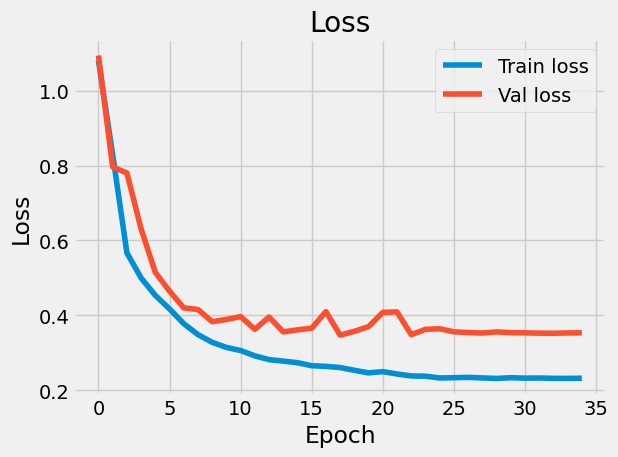

In [148]:
plot_loss(train_losses, valid_losses, False, 'KAN loss plot.png')

In [149]:
model = KAN([sequence_length * sequence_length * IN_CHANNELS, 32, OUTPUT_DIM], base_activation = torch.nn.Hardswish)

In [150]:
model.load_state_dict(torch.load("gdrive/MyDrive/ML/projects/predictive-maintenance/kan-binary-target-30.pt"))

<All keys matched successfully>

In [151]:
model

KAN(
  (layers): ModuleList(
    (0-1): 2 x KANLinear(
      (base_activation): Hardswish()
    )
  )
)

In [152]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

This code evaluates the trained neural network model on the test dataset and collects metrics to assess its performance.

In [153]:
test_loss, test_prec, test_rec = evaluate(model, test_iterator, criterion, device)

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

In [154]:
test_loss

0.4683667986820906

In [155]:
test_prec

0.6708663185667617

In [156]:
test_rec

0.8542121290692629

In [157]:
def get_predictions(model, iterator, device):

    labels = []
    probs = []

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.view(-1, sequence_length * sequence_length * IN_CHANNELS).to(device)

            x = x.to(device)

            y_pred = model(x)

            y_prob = sigmoid(y_pred)

            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return labels, probs

In [158]:
labels, probs = get_predictions(model, test_iterator, device)

In [159]:
precision, recall, thresholds = precision_recall_curve(labels, probs)

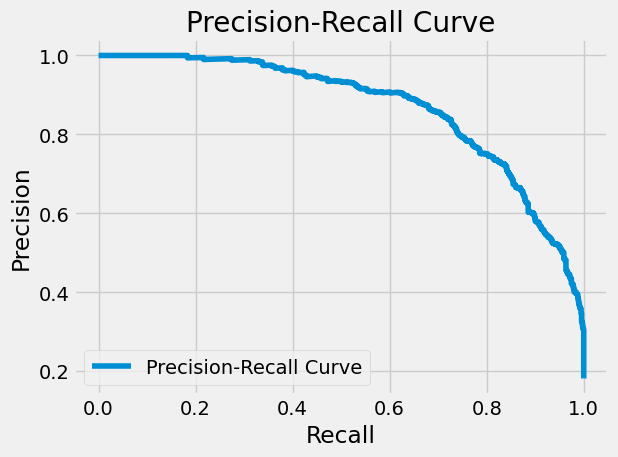

In [160]:
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.tight_layout()
#plt.savefig('KAN precision recall curve.png', dpi = 600)
plt.show()

In [161]:
pred_labels = t_round(probs).squeeze().long()

In [162]:
precision_score(labels.squeeze().numpy(), pred_labels.squeeze().numpy(), pos_label=1)

0.6730601569311246

In [163]:
recall_score(labels.squeeze().numpy(), pred_labels.squeeze().numpy(), pos_label=1)

0.8577777777777778

In [164]:
print(classification_report(labels.squeeze().numpy(), pred_labels.squeeze().numpy()))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      4074
           1       0.67      0.86      0.75       900

    accuracy                           0.90      4974
   macro avg       0.82      0.88      0.85      4974
weighted avg       0.91      0.90      0.90      4974



In [165]:
def plot_confusion_matrix(labels, pred_labels, classes, save_im = False, save_name = ''):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=0)

    if save_im:
      fig.savefig(save_name, dpi=600)

In [166]:
classes = [0, 1]

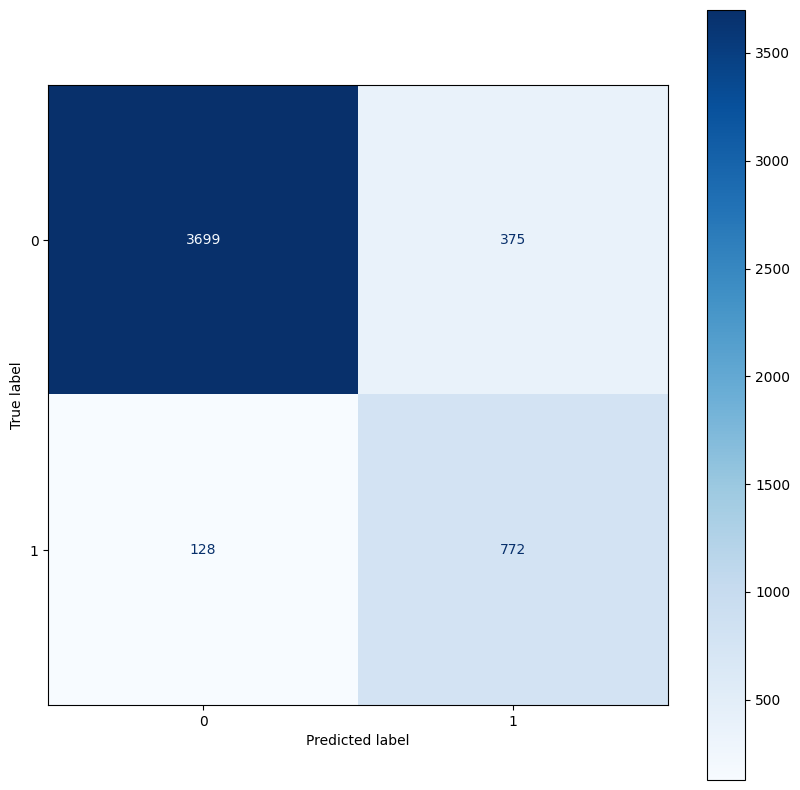

In [167]:
plt.style.use('default')
plot_confusion_matrix(labels, pred_labels, classes, save_im = False, save_name = 'KAN confusion matrix.png')

The code starts by constructing a DataFrame (pr_rec_df) to store precision, recall, and threshold values obtained during model evaluation. It then filters this DataFrame to retain rows where the recall is exactly 0.95, indicating a specific operating point of interest.

Next, it identifies the row with the highest precision value among those with a recall of 0.95. From this row, it extracts the corresponding threshold value, which is considered optimal for achieving a recall of 0.95.

In [168]:
pr_rec_df = pd.DataFrame({'Precision': precision[:-1], 'Recall': recall[:-1], 'Threshold': thresholds})

In [169]:
filtered_pr_rec_df = pr_rec_df[pr_rec_df['Recall'] == 0.95]

In [170]:
filtered_pr_rec_df

Precision  Recall  Threshold
3313    0.51475    0.95    0.19289

In [171]:
max_precision_row = filtered_pr_rec_df.loc[filtered_pr_rec_df['Precision'].idxmax()]
optimal_threshold = max_precision_row['Threshold']

In [172]:
optimal_threshold

0.19288989901542664

In [173]:
pred_labels_th = (probs >= optimal_threshold).squeeze().long()

In [174]:
print(classification_report(labels.squeeze().numpy(), pred_labels_th.squeeze().numpy()))

              precision    recall  f1-score   support

           0       0.99      0.80      0.88      4074
           1       0.51      0.95      0.67       900

    accuracy                           0.83      4974
   macro avg       0.75      0.88      0.78      4974
weighted avg       0.90      0.83      0.85      4974



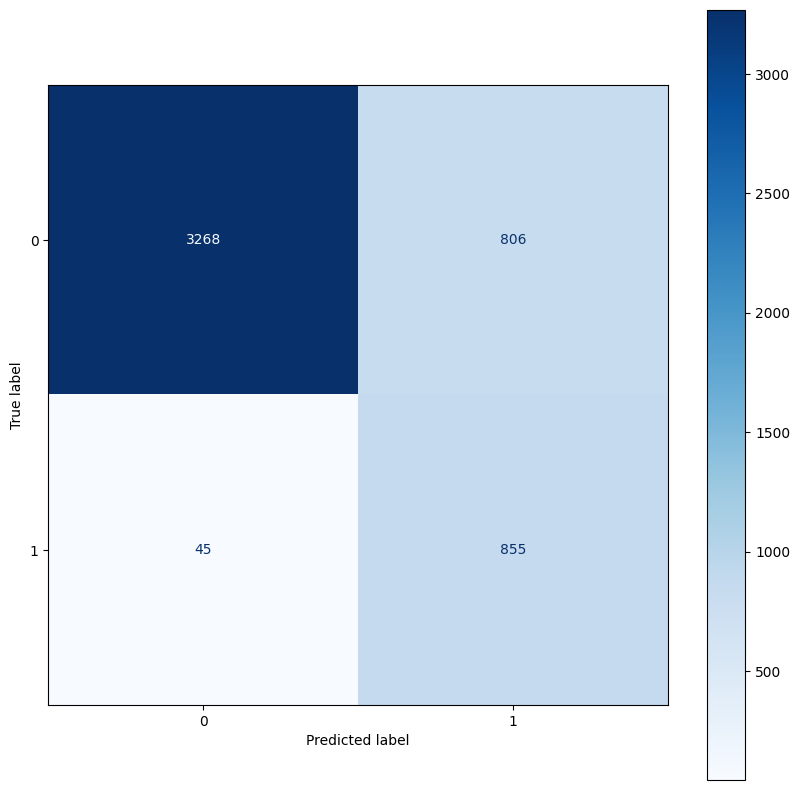

In [175]:
plt.style.use('default')
plot_confusion_matrix(labels, pred_labels_th, classes, save_im = False, save_name = 'KAN confusion matrix threshold.png')

#Approaches and Results

##Xception

The first approach involved treating the multivariate time series data as images of size 50x50, with the number of channels equal to the number of features. A popular pre-trained architecture, Xception, was fine-tuned to classify these images into one of the two categories described above. Unfortunately, this approach didn't show much promise as it tended to overfit and failed to achieve the desired level of performance in terms of predictive accuracy. This might be due to excessive noise in the sequenced data. Further improvements could be made experimenting with the length of the sequence, the logic behind recurrence plots, and the parameters of the neural network.

##KAN

The second approach utilized an implementation of the new KAN (Kolmogorov-Arnold Networks) architecture. This approach proved superior to the Xception model, demonstrating faster training times and more impressive results in terms of both loss and metrics. KAN's architecture and its ability to effectively handle the multivariate time series data made it particularly well-suited for this predictive maintenance task.

##Precision-recall threshold

An important aspect of predictive maintenance is the balance between precision and recall, particularly for classifying impending failure states. By experimenting with the threshold, it is possible to increase the recall for class 1 (impending failure state). While this may result in a decrease in precision, it ensures that more instances of potential failures are identified.

For practical applications, a strategy can be implemented where an engine is marked as approaching a state of failure only if several consecutive predictions indicate an impending failure. This approach helps mitigate the impact of occasional false positives, ensuring that maintenance actions are taken based on consistent and repeated indications of potential failure, thus enhancing the reliability of the predictive maintenance system.

##Conclusion

The research highlights the potential of KAN (Kolmogorov-Arnold Networks) in the field of predictive maintenance and reliability engineering. The superior performance of KAN, coupled with its fast training times and robust predictive capabilities, underscores its applicability for real-world scenarios where early detection of engine failures can lead to significant cost savings and improved operational safety. Future work can focus on further optimizing the thresholds and refining the decision-making criteria to balance precision and recall, ensuring a practical and effective maintenance strategy.

